In [4]:
import os
import cv2
import torch
import helper
import time
import random
from tqdm import tqdm
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn
from torch.nn import functional as F
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
import torchvision
import matplotlib.pyplot as plt

In [291]:
# define the path to the images and masks dataset
image_dataset_path = "dataset\\PPL"
mask_dataset_path = "dataset\\SE"

# define the test split
test_split = 0.10

# determine the device to be used for training and evaluation
device = "cuda" if torch.cuda.is_available() else "cpu"

torch.backends.cudnn.benchmark = True

#initialize learning rate, number of epochs to train for, and the batch size
init_lr = 1e-4
num_epochs = 500
batch_size = 5

# define the input image dimensions
input_image_width = 400
input_image_height = 400

# define the path to the base output directory
base_output = "output_6channel_SE"

# define the path to the output serialized model, model training plot, and testing image paths
model_path = os.path.join(base_output, "unet_model.pth")
plot_path = os.path.sep.join([base_output, "plot.png"])
test_paths = os.path.sep.join([base_output, "test_paths.txt"])

In [292]:
# load the image and mask filepaths in a sorted manner
imagePaths = os.listdir(image_dataset_path)
maskPaths = os.listdir(mask_dataset_path)
imageprefix = image_dataset_path + "\\"
maskprefix = mask_dataset_path + "\\"
imagePaths = [imageprefix + x for x in imagePaths]
maskPaths = [maskprefix + x for x in maskPaths]
# partition the data into training and testing splits using 85% of the data for training and the remaining 15% for testing
split = train_test_split(imagePaths, maskPaths, test_size=test_split, random_state=42)
# unpack the data split
(trainImages, testImages) = split[:2]
(trainMasks, testMasks) = split[2:]
# write the testing image paths to disk so that we can use then when evaluating/testing our model
print("[INFO] saving testing image paths...")
f = open(test_paths, "w")
f.write("\n".join(testImages))
f.close()

[INFO] saving testing image paths...


In [293]:
class SegmentationDataset(Dataset):
    def __init__(self, imagePaths, maskPaths, transforms):
        # store the image and mask filepaths, and augmentation transforms
        self.imagePaths = imagePaths
        self.maskPaths = maskPaths
        self.transforms = transforms
    def __len__(self):
        # return the number of total samples contained in the dataset
        return len(self.imagePaths)
    def __getitem__(self, idx):
        img_path = self.imagePaths[idx]
        mask_path = self.maskPaths[idx]
        img_1 = np.array(Image.open(img_path).convert("RGB"), dtype = np.float32) / 255.
        img_2_path = img_path.replace("PPL", "XPL")
        img_2 = np.array(Image.open(img_2_path).convert("RGB"), dtype = np.float32) / 255.
        image = np.concatenate((img_1, img_2), axis=-1)
        #image = img_1
        mask = np.array(Image.open(mask_path).convert("L"), dtype = np.float32) / 255.
        if self.transforms is not None:
            seed = np.random.randint(2147483647) 
            random.seed(seed) 
            torch.manual_seed(seed) 
            image = self.transforms(image)
            random.seed(seed) 
            torch.manual_seed(seed)
            mask = self.transforms(mask)
        return (image, mask)

In [294]:
# define transformations
transforms_ = transforms.Compose([transforms.ToTensor(), 
                                       transforms.RandomRotation(180),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomVerticalFlip()]) 

# create the train and test datasets
trainDS = SegmentationDataset(imagePaths=trainImages, maskPaths=trainMasks, transforms=transforms_)
testDS = SegmentationDataset(imagePaths=testImages, maskPaths=testMasks, transforms=transforms_)
print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(testDS)} examples in the test set...")
# create the training and test data loaders
trainLoader = DataLoader(trainDS, shuffle=True, batch_size=batch_size, pin_memory = True if device == "cuda" else False)
testLoader = DataLoader(testDS, shuffle=False, batch_size=batch_size, pin_memory= True if device == "cuda" else False)

[INFO] found 199 examples in the training set...
[INFO] found 23 examples in the test set...


In [295]:
# Run this to test your data loader
(images, masks) = next(iter(trainLoader))

In [296]:
print(f'x = shape: {images.shape}; type: {images.dtype}')
print(f'y = shape: {masks.shape}; type: {masks.dtype}')
print(f'x = min: {images.min()}; max: {images.max()}')
print(f'y = min: {masks.min()}; max: {masks.max()}')

x = shape: torch.Size([5, 6, 400, 400]); type: torch.float32
y = shape: torch.Size([5, 1, 400, 400]); type: torch.float32
x = min: 0.0; max: 1.0
y = min: 0.0; max: 0.9882352948188782


<AxesSubplot:>

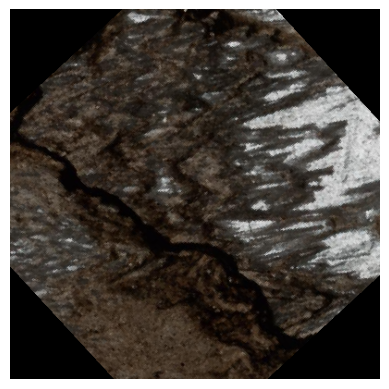

In [297]:
helper.imshow(images[0][0:3,:,:], normalize=False)

In [298]:
#helper.imshow(images[0][3:6,:,:], normalize=False)

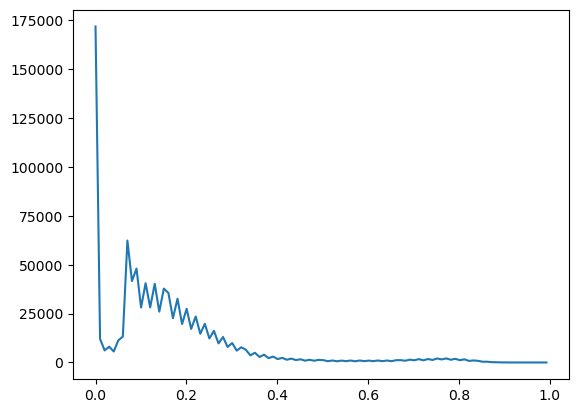

In [299]:
hist = images[0].histc()
images_min = images[0].min().item()
images_max = images[0].max().item()
plt.plot(torch.linspace(images_min, images_max, len(hist)), hist)
plt.show()

<AxesSubplot:>

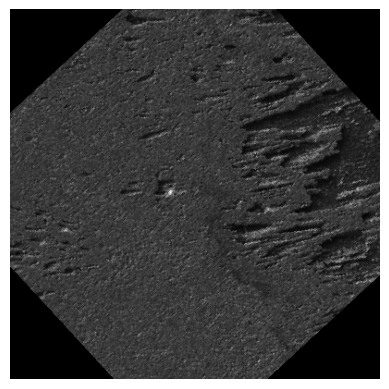

In [300]:
helper.imshow(masks[0], normalize=False, cmap='gray')

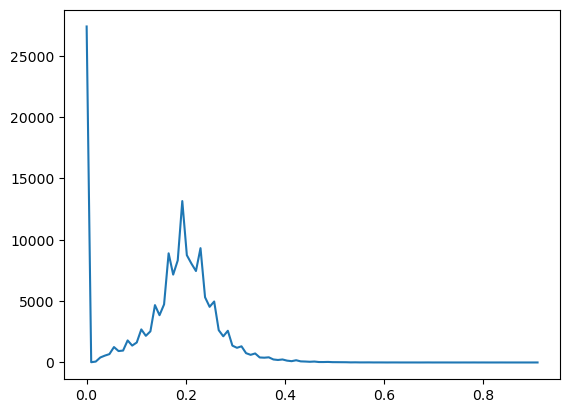

In [301]:
hist = masks[0].histc()
masks_min = masks[0].min().item()
masks_max = masks[0].max().item()
plt.plot(torch.linspace(masks_min, masks_max, len(hist)), hist)
plt.show()

In [302]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
        
    def forward(self, x):
        return self.conv(x)
    
class UNet(nn.Module):
    def __init__(
        self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNet, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # make sure the input is dividable by 16
        
        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature
            
        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))
            
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
    
    def forward(self, x):
        skip_connections = []
        
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
            
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]
        
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]
            
            # to solve the problem of input not dividable by 16
            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])
                
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)
            
        return self.final_conv(x)

In [303]:
# initialize our UNet model
unet = UNet(in_channels=6, out_channels=1).to(device)
# initialize loss function and optimizer
lossFunc = BCEWithLogitsLoss() # change to cross entropy loss for multi class
opt = Adam(unet.parameters(), lr=init_lr)
# calculate steps per epoch for training and test set
trainSteps = len(trainDS) // batch_size
testSteps = len(testDS) // batch_size
# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": []}

In [304]:
pred = unet(images.to(device))

In [305]:
loss = lossFunc(pred, masks.to(device))
print(loss)

tensor(0.8558, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


In [306]:
new_pred = pred.cpu()

In [307]:
new_pred = torch.sigmoid(new_pred)

<AxesSubplot:>

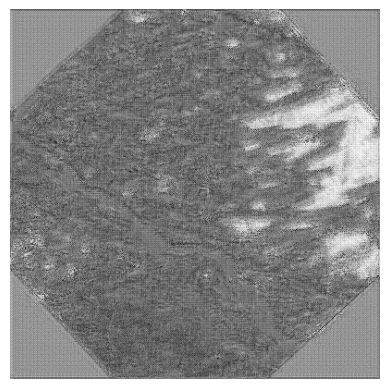

In [308]:
helper.imshow(new_pred[0].detach(), normalize=False, cmap='gray')

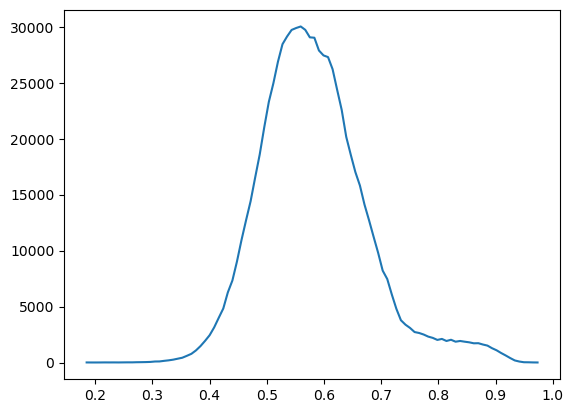

In [309]:
hist = new_pred.histc()
new_pred_min = new_pred.min().item()
new_pred_max = new_pred.max().item()
plt.plot(torch.linspace(new_pred_min, new_pred_max, len(hist)), hist)
plt.show()

[INFO] training the network...


  0%|▏                                                                               | 1/500 [00:15<2:06:11, 15.17s/it]

[INFO] EPOCH: 1/500
Train loss: 0.579177, Test loss: 0.6615


  0%|▎                                                                               | 2/500 [00:30<2:07:54, 15.41s/it]

[INFO] EPOCH: 2/500
Train loss: 0.502619, Test loss: 0.6136


  1%|▍                                                                               | 3/500 [00:47<2:14:13, 16.20s/it]

[INFO] EPOCH: 3/500
Train loss: 0.488767, Test loss: 0.6060


  1%|▋                                                                               | 4/500 [01:02<2:09:38, 15.68s/it]

[INFO] EPOCH: 4/500
Train loss: 0.482955, Test loss: 0.5966


  1%|▊                                                                               | 5/500 [01:18<2:08:53, 15.62s/it]

[INFO] EPOCH: 5/500
Train loss: 0.479341, Test loss: 0.5808


  1%|▉                                                                               | 6/500 [01:33<2:08:07, 15.56s/it]

[INFO] EPOCH: 6/500
Train loss: 0.475644, Test loss: 0.5782


  1%|█                                                                               | 7/500 [01:49<2:07:15, 15.49s/it]

[INFO] EPOCH: 7/500
Train loss: 0.473899, Test loss: 0.5904


  2%|█▎                                                                              | 8/500 [02:04<2:07:41, 15.57s/it]

[INFO] EPOCH: 8/500
Train loss: 0.472245, Test loss: 0.5729


  2%|█▍                                                                              | 9/500 [02:23<2:15:17, 16.53s/it]

[INFO] EPOCH: 9/500
Train loss: 0.472678, Test loss: 0.5757


  2%|█▌                                                                             | 10/500 [02:41<2:19:02, 17.03s/it]

[INFO] EPOCH: 10/500
Train loss: 0.471863, Test loss: 0.5809


  2%|█▋                                                                             | 11/500 [03:00<2:23:40, 17.63s/it]

[INFO] EPOCH: 11/500
Train loss: 0.466925, Test loss: 0.5758


  2%|█▉                                                                             | 12/500 [03:16<2:18:25, 17.02s/it]

[INFO] EPOCH: 12/500
Train loss: 0.468190, Test loss: 0.5800


  3%|██                                                                             | 13/500 [03:31<2:13:12, 16.41s/it]

[INFO] EPOCH: 13/500
Train loss: 0.469449, Test loss: 0.5780


  3%|██▏                                                                            | 14/500 [03:46<2:09:56, 16.04s/it]

[INFO] EPOCH: 14/500
Train loss: 0.466406, Test loss: 0.5714


  3%|██▎                                                                            | 15/500 [04:02<2:08:50, 15.94s/it]

[INFO] EPOCH: 15/500
Train loss: 0.469097, Test loss: 0.5732


  3%|██▌                                                                            | 16/500 [04:17<2:06:55, 15.73s/it]

[INFO] EPOCH: 16/500
Train loss: 0.465828, Test loss: 0.5654


  3%|██▋                                                                            | 17/500 [04:32<2:05:11, 15.55s/it]

[INFO] EPOCH: 17/500
Train loss: 0.463831, Test loss: 0.5733


  4%|██▊                                                                            | 18/500 [04:47<2:03:54, 15.42s/it]

[INFO] EPOCH: 18/500
Train loss: 0.468055, Test loss: 0.5828


  4%|███                                                                            | 19/500 [05:02<2:02:59, 15.34s/it]

[INFO] EPOCH: 19/500
Train loss: 0.463574, Test loss: 0.5651


  4%|███▏                                                                           | 20/500 [05:17<2:02:23, 15.30s/it]

[INFO] EPOCH: 20/500
Train loss: 0.467274, Test loss: 0.5687


  4%|███▎                                                                           | 21/500 [05:33<2:01:45, 15.25s/it]

[INFO] EPOCH: 21/500
Train loss: 0.462406, Test loss: 0.5829


  4%|███▍                                                                           | 22/500 [05:48<2:01:33, 15.26s/it]

[INFO] EPOCH: 22/500
Train loss: 0.466839, Test loss: 0.5714


  5%|███▋                                                                           | 23/500 [06:03<2:00:58, 15.22s/it]

[INFO] EPOCH: 23/500
Train loss: 0.463239, Test loss: 0.5615


  5%|███▊                                                                           | 24/500 [06:18<2:00:56, 15.24s/it]

[INFO] EPOCH: 24/500
Train loss: 0.464157, Test loss: 0.5723


  5%|███▉                                                                           | 25/500 [06:33<2:00:07, 15.17s/it]

[INFO] EPOCH: 25/500
Train loss: 0.465744, Test loss: 0.5639


  5%|████                                                                           | 26/500 [06:48<1:59:42, 15.15s/it]

[INFO] EPOCH: 26/500
Train loss: 0.463002, Test loss: 0.5731


  5%|████▎                                                                          | 27/500 [07:04<1:59:14, 15.13s/it]

[INFO] EPOCH: 27/500
Train loss: 0.463066, Test loss: 0.5766


  6%|████▍                                                                          | 28/500 [07:19<1:59:50, 15.23s/it]

[INFO] EPOCH: 28/500
Train loss: 0.463702, Test loss: 0.5580


  6%|████▌                                                                          | 29/500 [07:37<2:06:59, 16.18s/it]

[INFO] EPOCH: 29/500
Train loss: 0.464449, Test loss: 0.5705


  6%|████▋                                                                          | 30/500 [07:52<2:04:03, 15.84s/it]

[INFO] EPOCH: 30/500
Train loss: 0.464099, Test loss: 0.5796


  6%|████▉                                                                          | 31/500 [08:07<2:02:00, 15.61s/it]

[INFO] EPOCH: 31/500
Train loss: 0.465328, Test loss: 0.5707


  6%|█████                                                                          | 32/500 [08:23<2:01:38, 15.60s/it]

[INFO] EPOCH: 32/500
Train loss: 0.468309, Test loss: 0.5743


  7%|█████▏                                                                         | 33/500 [08:38<2:00:21, 15.46s/it]

[INFO] EPOCH: 33/500
Train loss: 0.466083, Test loss: 0.5636


  7%|█████▎                                                                         | 34/500 [08:53<1:59:35, 15.40s/it]

[INFO] EPOCH: 34/500
Train loss: 0.464152, Test loss: 0.5873


  7%|█████▌                                                                         | 35/500 [09:09<1:58:52, 15.34s/it]

[INFO] EPOCH: 35/500
Train loss: 0.463424, Test loss: 0.5674


  7%|█████▋                                                                         | 36/500 [09:24<1:58:18, 15.30s/it]

[INFO] EPOCH: 36/500
Train loss: 0.465097, Test loss: 0.5662


  7%|█████▊                                                                         | 37/500 [09:39<1:57:33, 15.23s/it]

[INFO] EPOCH: 37/500
Train loss: 0.467182, Test loss: 0.5728


  8%|██████                                                                         | 38/500 [09:54<1:56:54, 15.18s/it]

[INFO] EPOCH: 38/500
Train loss: 0.464326, Test loss: 0.5753


  8%|██████▏                                                                        | 39/500 [10:10<1:58:51, 15.47s/it]

[INFO] EPOCH: 39/500
Train loss: 0.463454, Test loss: 0.5689


  8%|██████▎                                                                        | 40/500 [10:27<2:01:07, 15.80s/it]

[INFO] EPOCH: 40/500
Train loss: 0.462649, Test loss: 0.5779


  8%|██████▍                                                                        | 41/500 [10:42<1:59:31, 15.62s/it]

[INFO] EPOCH: 41/500
Train loss: 0.465070, Test loss: 0.5586


  8%|██████▋                                                                        | 42/500 [10:57<1:58:07, 15.47s/it]

[INFO] EPOCH: 42/500
Train loss: 0.464078, Test loss: 0.5705


  9%|██████▊                                                                        | 43/500 [11:12<1:57:35, 15.44s/it]

[INFO] EPOCH: 43/500
Train loss: 0.463975, Test loss: 0.5635


  9%|██████▉                                                                        | 44/500 [11:28<1:56:40, 15.35s/it]

[INFO] EPOCH: 44/500
Train loss: 0.462954, Test loss: 0.5685


  9%|███████                                                                        | 45/500 [11:44<1:58:24, 15.61s/it]

[INFO] EPOCH: 45/500
Train loss: 0.463235, Test loss: 0.5604


  9%|███████▎                                                                       | 46/500 [12:00<1:59:38, 15.81s/it]

[INFO] EPOCH: 46/500
Train loss: 0.462087, Test loss: 0.5714


  9%|███████▍                                                                       | 47/500 [12:17<2:01:23, 16.08s/it]

[INFO] EPOCH: 47/500
Train loss: 0.462780, Test loss: 0.5674


 10%|███████▌                                                                       | 48/500 [12:33<2:01:43, 16.16s/it]

[INFO] EPOCH: 48/500
Train loss: 0.464959, Test loss: 0.5683


 10%|███████▋                                                                       | 49/500 [12:49<2:01:58, 16.23s/it]

[INFO] EPOCH: 49/500
Train loss: 0.462469, Test loss: 0.5705


 10%|███████▉                                                                       | 50/500 [13:06<2:02:06, 16.28s/it]

[INFO] EPOCH: 50/500
Train loss: 0.460170, Test loss: 0.5710


 10%|████████                                                                       | 51/500 [13:22<2:02:05, 16.31s/it]

[INFO] EPOCH: 51/500
Train loss: 0.461325, Test loss: 0.5736


 10%|████████▏                                                                      | 52/500 [13:39<2:02:13, 16.37s/it]

[INFO] EPOCH: 52/500
Train loss: 0.460225, Test loss: 0.5668


 11%|████████▎                                                                      | 53/500 [13:55<2:01:49, 16.35s/it]

[INFO] EPOCH: 53/500
Train loss: 0.461554, Test loss: 0.5677


 11%|████████▌                                                                      | 54/500 [14:11<2:01:33, 16.35s/it]

[INFO] EPOCH: 54/500
Train loss: 0.460448, Test loss: 0.5755


 11%|████████▋                                                                      | 55/500 [14:28<2:01:18, 16.36s/it]

[INFO] EPOCH: 55/500
Train loss: 0.465184, Test loss: 0.5784


 11%|████████▊                                                                      | 56/500 [14:44<2:01:13, 16.38s/it]

[INFO] EPOCH: 56/500
Train loss: 0.465592, Test loss: 0.5748


 11%|█████████                                                                      | 57/500 [15:01<2:00:51, 16.37s/it]

[INFO] EPOCH: 57/500
Train loss: 0.461711, Test loss: 0.5616


 12%|█████████▏                                                                     | 58/500 [15:17<2:00:46, 16.39s/it]

[INFO] EPOCH: 58/500
Train loss: 0.465347, Test loss: 0.5648


 12%|█████████▎                                                                     | 59/500 [15:33<2:00:26, 16.39s/it]

[INFO] EPOCH: 59/500
Train loss: 0.461883, Test loss: 0.5662


 12%|█████████▍                                                                     | 60/500 [15:50<1:59:56, 16.36s/it]

[INFO] EPOCH: 60/500
Train loss: 0.463302, Test loss: 0.5813


 12%|█████████▋                                                                     | 61/500 [16:06<1:59:29, 16.33s/it]

[INFO] EPOCH: 61/500
Train loss: 0.466615, Test loss: 0.5629


 12%|█████████▊                                                                     | 62/500 [16:22<1:59:32, 16.38s/it]

[INFO] EPOCH: 62/500
Train loss: 0.463746, Test loss: 0.5565


 13%|█████████▉                                                                     | 63/500 [16:39<1:59:35, 16.42s/it]

[INFO] EPOCH: 63/500
Train loss: 0.460199, Test loss: 0.5554


 13%|██████████                                                                     | 64/500 [16:55<1:59:06, 16.39s/it]

[INFO] EPOCH: 64/500
Train loss: 0.460933, Test loss: 0.5685


 13%|██████████▎                                                                    | 65/500 [17:12<1:58:53, 16.40s/it]

[INFO] EPOCH: 65/500
Train loss: 0.468153, Test loss: 0.5621


 13%|██████████▍                                                                    | 66/500 [17:28<1:58:23, 16.37s/it]

[INFO] EPOCH: 66/500
Train loss: 0.462463, Test loss: 0.5681


 13%|██████████▌                                                                    | 67/500 [17:44<1:58:16, 16.39s/it]

[INFO] EPOCH: 67/500
Train loss: 0.462683, Test loss: 0.5639


 14%|██████████▋                                                                    | 68/500 [18:01<1:58:01, 16.39s/it]

[INFO] EPOCH: 68/500
Train loss: 0.463321, Test loss: 0.5695


 14%|██████████▉                                                                    | 69/500 [18:17<1:57:27, 16.35s/it]

[INFO] EPOCH: 69/500
Train loss: 0.464202, Test loss: 0.5733


 14%|███████████                                                                    | 70/500 [18:34<1:57:35, 16.41s/it]

[INFO] EPOCH: 70/500
Train loss: 0.462184, Test loss: 0.5756


 14%|███████████▏                                                                   | 71/500 [18:50<1:57:00, 16.36s/it]

[INFO] EPOCH: 71/500
Train loss: 0.462566, Test loss: 0.5635


 14%|███████████▍                                                                   | 72/500 [19:06<1:56:56, 16.39s/it]

[INFO] EPOCH: 72/500
Train loss: 0.464396, Test loss: 0.5687


 15%|███████████▌                                                                   | 73/500 [19:23<1:56:27, 16.36s/it]

[INFO] EPOCH: 73/500
Train loss: 0.461821, Test loss: 0.5759


 15%|███████████▋                                                                   | 74/500 [19:40<1:58:39, 16.71s/it]

[INFO] EPOCH: 74/500
Train loss: 0.461374, Test loss: 0.5726


 15%|███████████▊                                                                   | 75/500 [19:57<1:57:34, 16.60s/it]

[INFO] EPOCH: 75/500
Train loss: 0.461230, Test loss: 0.5540


 15%|████████████                                                                   | 76/500 [20:13<1:56:28, 16.48s/it]

[INFO] EPOCH: 76/500
Train loss: 0.464048, Test loss: 0.5727


 15%|████████████▏                                                                  | 77/500 [20:29<1:56:06, 16.47s/it]

[INFO] EPOCH: 77/500
Train loss: 0.465475, Test loss: 0.5729


 16%|████████████▎                                                                  | 78/500 [20:46<1:55:32, 16.43s/it]

[INFO] EPOCH: 78/500
Train loss: 0.462832, Test loss: 0.5657


 16%|████████████▍                                                                  | 79/500 [21:02<1:55:48, 16.50s/it]

[INFO] EPOCH: 79/500
Train loss: 0.463861, Test loss: 0.5624


 16%|████████████▋                                                                  | 80/500 [21:18<1:54:46, 16.40s/it]

[INFO] EPOCH: 80/500
Train loss: 0.462456, Test loss: 0.5793


 16%|████████████▊                                                                  | 81/500 [21:35<1:54:57, 16.46s/it]

[INFO] EPOCH: 81/500
Train loss: 0.462808, Test loss: 0.5744


 16%|████████████▉                                                                  | 82/500 [21:51<1:54:23, 16.42s/it]

[INFO] EPOCH: 82/500
Train loss: 0.465054, Test loss: 0.5723


 17%|█████████████                                                                  | 83/500 [22:08<1:54:06, 16.42s/it]

[INFO] EPOCH: 83/500
Train loss: 0.464694, Test loss: 0.5726


 17%|█████████████▎                                                                 | 84/500 [22:24<1:53:34, 16.38s/it]

[INFO] EPOCH: 84/500
Train loss: 0.460043, Test loss: 0.5780


 17%|█████████████▍                                                                 | 85/500 [22:43<1:59:26, 17.27s/it]

[INFO] EPOCH: 85/500
Train loss: 0.460669, Test loss: 0.5729


 17%|█████████████▌                                                                 | 86/500 [23:00<1:57:18, 17.00s/it]

[INFO] EPOCH: 86/500
Train loss: 0.462766, Test loss: 0.5681


 17%|█████████████▋                                                                 | 87/500 [23:16<1:55:23, 16.76s/it]

[INFO] EPOCH: 87/500
Train loss: 0.463002, Test loss: 0.5790


 18%|█████████████▉                                                                 | 88/500 [23:32<1:54:26, 16.67s/it]

[INFO] EPOCH: 88/500
Train loss: 0.463657, Test loss: 0.5730


 18%|██████████████                                                                 | 89/500 [23:49<1:53:10, 16.52s/it]

[INFO] EPOCH: 89/500
Train loss: 0.461398, Test loss: 0.5661


 18%|██████████████▏                                                                | 90/500 [24:05<1:52:48, 16.51s/it]

[INFO] EPOCH: 90/500
Train loss: 0.463207, Test loss: 0.5702


 18%|██████████████▍                                                                | 91/500 [24:21<1:52:12, 16.46s/it]

[INFO] EPOCH: 91/500
Train loss: 0.462590, Test loss: 0.5619


 18%|██████████████▌                                                                | 92/500 [24:38<1:52:18, 16.52s/it]

[INFO] EPOCH: 92/500
Train loss: 0.464108, Test loss: 0.5694


 19%|██████████████▋                                                                | 93/500 [24:54<1:51:44, 16.47s/it]

[INFO] EPOCH: 93/500
Train loss: 0.463474, Test loss: 0.5758


 19%|██████████████▊                                                                | 94/500 [25:11<1:51:09, 16.43s/it]

[INFO] EPOCH: 94/500
Train loss: 0.461675, Test loss: 0.5706


 19%|███████████████                                                                | 95/500 [25:27<1:50:52, 16.43s/it]

[INFO] EPOCH: 95/500
Train loss: 0.464054, Test loss: 0.5713


 19%|███████████████▏                                                               | 96/500 [25:43<1:50:14, 16.37s/it]

[INFO] EPOCH: 96/500
Train loss: 0.463449, Test loss: 0.5677


 19%|███████████████▎                                                               | 97/500 [26:00<1:50:02, 16.38s/it]

[INFO] EPOCH: 97/500
Train loss: 0.461942, Test loss: 0.5738


 20%|███████████████▍                                                               | 98/500 [26:16<1:49:18, 16.31s/it]

[INFO] EPOCH: 98/500
Train loss: 0.465556, Test loss: 0.5858


 20%|███████████████▋                                                               | 99/500 [26:32<1:49:25, 16.37s/it]

[INFO] EPOCH: 99/500
Train loss: 0.464575, Test loss: 0.5654


 20%|███████████████▌                                                              | 100/500 [26:49<1:49:14, 16.39s/it]

[INFO] EPOCH: 100/500
Train loss: 0.463823, Test loss: 0.5707


 20%|███████████████▊                                                              | 101/500 [27:05<1:48:44, 16.35s/it]

[INFO] EPOCH: 101/500
Train loss: 0.463390, Test loss: 0.5650


 20%|███████████████▉                                                              | 102/500 [27:21<1:48:22, 16.34s/it]

[INFO] EPOCH: 102/500
Train loss: 0.465640, Test loss: 0.5884


 21%|████████████████                                                              | 103/500 [27:38<1:47:55, 16.31s/it]

[INFO] EPOCH: 103/500
Train loss: 0.463969, Test loss: 0.5844


 21%|████████████████▏                                                             | 104/500 [27:54<1:47:50, 16.34s/it]

[INFO] EPOCH: 104/500
Train loss: 0.463404, Test loss: 0.5696


 21%|████████████████▍                                                             | 105/500 [28:10<1:47:19, 16.30s/it]

[INFO] EPOCH: 105/500
Train loss: 0.465649, Test loss: 0.5725


 21%|████████████████▌                                                             | 106/500 [28:27<1:48:17, 16.49s/it]

[INFO] EPOCH: 106/500
Train loss: 0.462379, Test loss: 0.5728


 21%|████████████████▋                                                             | 107/500 [28:44<1:47:37, 16.43s/it]

[INFO] EPOCH: 107/500
Train loss: 0.461834, Test loss: 0.5654


 22%|████████████████▊                                                             | 108/500 [29:00<1:47:24, 16.44s/it]

[INFO] EPOCH: 108/500
Train loss: 0.463523, Test loss: 0.5804


 22%|█████████████████                                                             | 109/500 [29:17<1:48:34, 16.66s/it]

[INFO] EPOCH: 109/500
Train loss: 0.462778, Test loss: 0.5594


 22%|█████████████████▏                                                            | 110/500 [29:33<1:47:29, 16.54s/it]

[INFO] EPOCH: 110/500
Train loss: 0.466152, Test loss: 0.5689


 22%|█████████████████▎                                                            | 111/500 [29:50<1:46:32, 16.43s/it]

[INFO] EPOCH: 111/500
Train loss: 0.468414, Test loss: 0.5869


 22%|█████████████████▍                                                            | 112/500 [30:06<1:45:54, 16.38s/it]

[INFO] EPOCH: 112/500
Train loss: 0.462760, Test loss: 0.5696


 23%|█████████████████▋                                                            | 113/500 [30:22<1:46:02, 16.44s/it]

[INFO] EPOCH: 113/500
Train loss: 0.462719, Test loss: 0.5688


 23%|█████████████████▊                                                            | 114/500 [30:39<1:45:49, 16.45s/it]

[INFO] EPOCH: 114/500
Train loss: 0.458722, Test loss: 0.5599


 23%|█████████████████▉                                                            | 115/500 [30:55<1:45:41, 16.47s/it]

[INFO] EPOCH: 115/500
Train loss: 0.463303, Test loss: 0.5766


 23%|██████████████████                                                            | 116/500 [31:12<1:45:00, 16.41s/it]

[INFO] EPOCH: 116/500
Train loss: 0.465906, Test loss: 0.5650


 23%|██████████████████▎                                                           | 117/500 [31:28<1:44:43, 16.41s/it]

[INFO] EPOCH: 117/500
Train loss: 0.460912, Test loss: 0.5636


 24%|██████████████████▍                                                           | 118/500 [31:45<1:44:26, 16.40s/it]

[INFO] EPOCH: 118/500
Train loss: 0.461608, Test loss: 0.5672


 24%|██████████████████▌                                                           | 119/500 [32:01<1:44:10, 16.41s/it]

[INFO] EPOCH: 119/500
Train loss: 0.463390, Test loss: 0.5801


 24%|██████████████████▋                                                           | 120/500 [32:17<1:44:09, 16.45s/it]

[INFO] EPOCH: 120/500
Train loss: 0.462337, Test loss: 0.5618


 24%|██████████████████▉                                                           | 121/500 [32:34<1:43:57, 16.46s/it]

[INFO] EPOCH: 121/500
Train loss: 0.460506, Test loss: 0.5690


 24%|███████████████████                                                           | 122/500 [32:50<1:43:49, 16.48s/it]

[INFO] EPOCH: 122/500
Train loss: 0.460638, Test loss: 0.5671


 25%|███████████████████▏                                                          | 123/500 [33:07<1:42:50, 16.37s/it]

[INFO] EPOCH: 123/500
Train loss: 0.466591, Test loss: 0.5690


 25%|███████████████████▎                                                          | 124/500 [33:23<1:42:37, 16.38s/it]

[INFO] EPOCH: 124/500
Train loss: 0.464796, Test loss: 0.5730


 25%|███████████████████▌                                                          | 125/500 [33:39<1:42:15, 16.36s/it]

[INFO] EPOCH: 125/500
Train loss: 0.462664, Test loss: 0.5611


 25%|███████████████████▋                                                          | 126/500 [33:56<1:42:08, 16.39s/it]

[INFO] EPOCH: 126/500
Train loss: 0.461500, Test loss: 0.5709


 25%|███████████████████▊                                                          | 127/500 [34:12<1:41:34, 16.34s/it]

[INFO] EPOCH: 127/500
Train loss: 0.462561, Test loss: 0.5679


 26%|███████████████████▉                                                          | 128/500 [34:28<1:41:34, 16.38s/it]

[INFO] EPOCH: 128/500
Train loss: 0.462420, Test loss: 0.5645


 26%|████████████████████                                                          | 129/500 [34:45<1:41:20, 16.39s/it]

[INFO] EPOCH: 129/500
Train loss: 0.462015, Test loss: 0.5665


 26%|████████████████████▎                                                         | 130/500 [35:01<1:41:04, 16.39s/it]

[INFO] EPOCH: 130/500
Train loss: 0.459097, Test loss: 0.5668


 26%|████████████████████▍                                                         | 131/500 [35:18<1:40:58, 16.42s/it]

[INFO] EPOCH: 131/500
Train loss: 0.460782, Test loss: 0.5571


 26%|████████████████████▌                                                         | 132/500 [35:34<1:40:34, 16.40s/it]

[INFO] EPOCH: 132/500
Train loss: 0.460886, Test loss: 0.5686


 27%|████████████████████▋                                                         | 133/500 [35:51<1:40:24, 16.42s/it]

[INFO] EPOCH: 133/500
Train loss: 0.462269, Test loss: 0.5646


 27%|████████████████████▉                                                         | 134/500 [36:07<1:39:54, 16.38s/it]

[INFO] EPOCH: 134/500
Train loss: 0.463234, Test loss: 0.5666


 27%|█████████████████████                                                         | 135/500 [36:23<1:39:42, 16.39s/it]

[INFO] EPOCH: 135/500
Train loss: 0.463428, Test loss: 0.5699


 27%|█████████████████████▏                                                        | 136/500 [36:40<1:39:22, 16.38s/it]

[INFO] EPOCH: 136/500
Train loss: 0.460648, Test loss: 0.5662


 27%|█████████████████████▎                                                        | 137/500 [36:56<1:39:08, 16.39s/it]

[INFO] EPOCH: 137/500
Train loss: 0.460861, Test loss: 0.5668


 28%|█████████████████████▌                                                        | 138/500 [37:12<1:38:57, 16.40s/it]

[INFO] EPOCH: 138/500
Train loss: 0.458860, Test loss: 0.5663


 28%|█████████████████████▋                                                        | 139/500 [37:29<1:38:24, 16.36s/it]

[INFO] EPOCH: 139/500
Train loss: 0.458816, Test loss: 0.5871


 28%|█████████████████████▊                                                        | 140/500 [37:48<1:43:30, 17.25s/it]

[INFO] EPOCH: 140/500
Train loss: 0.461058, Test loss: 0.5597


 28%|█████████████████████▉                                                        | 141/500 [38:04<1:41:18, 16.93s/it]

[INFO] EPOCH: 141/500
Train loss: 0.462265, Test loss: 0.5675


 28%|██████████████████████▏                                                       | 142/500 [38:21<1:40:14, 16.80s/it]

[INFO] EPOCH: 142/500
Train loss: 0.462594, Test loss: 0.5724


 29%|██████████████████████▎                                                       | 143/500 [38:38<1:41:09, 17.00s/it]

[INFO] EPOCH: 143/500
Train loss: 0.460915, Test loss: 0.5707


 29%|██████████████████████▍                                                       | 144/500 [38:54<1:39:35, 16.79s/it]

[INFO] EPOCH: 144/500
Train loss: 0.461786, Test loss: 0.5700


 29%|██████████████████████▌                                                       | 145/500 [39:11<1:38:29, 16.65s/it]

[INFO] EPOCH: 145/500
Train loss: 0.459758, Test loss: 0.5725


 29%|██████████████████████▊                                                       | 146/500 [39:27<1:37:47, 16.58s/it]

[INFO] EPOCH: 146/500
Train loss: 0.460093, Test loss: 0.5778


 29%|██████████████████████▉                                                       | 147/500 [39:44<1:37:05, 16.50s/it]

[INFO] EPOCH: 147/500
Train loss: 0.462248, Test loss: 0.5757


 30%|███████████████████████                                                       | 148/500 [40:00<1:36:44, 16.49s/it]

[INFO] EPOCH: 148/500
Train loss: 0.460939, Test loss: 0.5739


 30%|███████████████████████▏                                                      | 149/500 [40:18<1:38:41, 16.87s/it]

[INFO] EPOCH: 149/500
Train loss: 0.462353, Test loss: 0.5805


 30%|███████████████████████▍                                                      | 150/500 [40:34<1:37:13, 16.67s/it]

[INFO] EPOCH: 150/500
Train loss: 0.464495, Test loss: 0.5642


 30%|███████████████████████▌                                                      | 151/500 [40:50<1:36:39, 16.62s/it]

[INFO] EPOCH: 151/500
Train loss: 0.461135, Test loss: 0.5722


 30%|███████████████████████▋                                                      | 152/500 [41:07<1:35:37, 16.49s/it]

[INFO] EPOCH: 152/500
Train loss: 0.463980, Test loss: 0.5705


 31%|███████████████████████▊                                                      | 153/500 [41:23<1:35:19, 16.48s/it]

[INFO] EPOCH: 153/500
Train loss: 0.457108, Test loss: 0.5634


 31%|████████████████████████                                                      | 154/500 [41:40<1:34:58, 16.47s/it]

[INFO] EPOCH: 154/500
Train loss: 0.461964, Test loss: 0.5667


 31%|████████████████████████▏                                                     | 155/500 [41:56<1:34:26, 16.42s/it]

[INFO] EPOCH: 155/500
Train loss: 0.460898, Test loss: 0.5676


 31%|████████████████████████▎                                                     | 156/500 [42:12<1:34:02, 16.40s/it]

[INFO] EPOCH: 156/500
Train loss: 0.462376, Test loss: 0.5724


 31%|████████████████████████▍                                                     | 157/500 [42:28<1:33:22, 16.33s/it]

[INFO] EPOCH: 157/500
Train loss: 0.463098, Test loss: 0.5619


 32%|████████████████████████▋                                                     | 158/500 [42:45<1:33:34, 16.42s/it]

[INFO] EPOCH: 158/500
Train loss: 0.462353, Test loss: 0.5663


 32%|████████████████████████▊                                                     | 159/500 [43:01<1:33:04, 16.38s/it]

[INFO] EPOCH: 159/500
Train loss: 0.459610, Test loss: 0.5659


 32%|████████████████████████▉                                                     | 160/500 [43:18<1:32:59, 16.41s/it]

[INFO] EPOCH: 160/500
Train loss: 0.459144, Test loss: 0.5610


 32%|█████████████████████████                                                     | 161/500 [43:34<1:32:26, 16.36s/it]

[INFO] EPOCH: 161/500
Train loss: 0.462471, Test loss: 0.5587


 32%|█████████████████████████▎                                                    | 162/500 [43:51<1:32:24, 16.41s/it]

[INFO] EPOCH: 162/500
Train loss: 0.458972, Test loss: 0.5668


 33%|█████████████████████████▍                                                    | 163/500 [44:07<1:32:12, 16.42s/it]

[INFO] EPOCH: 163/500
Train loss: 0.459102, Test loss: 0.5666


 33%|█████████████████████████▌                                                    | 164/500 [44:23<1:31:33, 16.35s/it]

[INFO] EPOCH: 164/500
Train loss: 0.462409, Test loss: 0.5743


 33%|█████████████████████████▋                                                    | 165/500 [44:39<1:31:12, 16.34s/it]

[INFO] EPOCH: 165/500
Train loss: 0.459651, Test loss: 0.5755


 33%|█████████████████████████▉                                                    | 166/500 [44:56<1:30:53, 16.33s/it]

[INFO] EPOCH: 166/500
Train loss: 0.464198, Test loss: 0.5728


 33%|██████████████████████████                                                    | 167/500 [45:12<1:30:40, 16.34s/it]

[INFO] EPOCH: 167/500
Train loss: 0.461206, Test loss: 0.5642


 34%|██████████████████████████▏                                                   | 168/500 [45:34<1:40:04, 18.09s/it]

[INFO] EPOCH: 168/500
Train loss: 0.462423, Test loss: 0.5698


 34%|██████████████████████████▎                                                   | 169/500 [45:51<1:37:09, 17.61s/it]

[INFO] EPOCH: 169/500
Train loss: 0.462794, Test loss: 0.5649


 34%|██████████████████████████▌                                                   | 170/500 [46:07<1:35:00, 17.27s/it]

[INFO] EPOCH: 170/500
Train loss: 0.460590, Test loss: 0.5678


 34%|██████████████████████████▋                                                   | 171/500 [46:24<1:33:38, 17.08s/it]

[INFO] EPOCH: 171/500
Train loss: 0.463403, Test loss: 0.5634


 34%|██████████████████████████▊                                                   | 172/500 [46:40<1:32:18, 16.89s/it]

[INFO] EPOCH: 172/500
Train loss: 0.459113, Test loss: 0.5663


 35%|██████████████████████████▉                                                   | 173/500 [46:57<1:31:22, 16.77s/it]

[INFO] EPOCH: 173/500
Train loss: 0.458229, Test loss: 0.5565


 35%|███████████████████████████▏                                                  | 174/500 [47:13<1:30:35, 16.67s/it]

[INFO] EPOCH: 174/500
Train loss: 0.458768, Test loss: 0.5636


 35%|███████████████████████████▎                                                  | 175/500 [47:30<1:29:34, 16.54s/it]

[INFO] EPOCH: 175/500
Train loss: 0.459756, Test loss: 0.5652


 35%|███████████████████████████▍                                                  | 176/500 [47:46<1:29:17, 16.54s/it]

[INFO] EPOCH: 176/500
Train loss: 0.460782, Test loss: 0.5653


 35%|███████████████████████████▌                                                  | 177/500 [48:03<1:30:03, 16.73s/it]

[INFO] EPOCH: 177/500
Train loss: 0.461820, Test loss: 0.5804


 36%|███████████████████████████▊                                                  | 178/500 [48:20<1:29:43, 16.72s/it]

[INFO] EPOCH: 178/500
Train loss: 0.459258, Test loss: 0.5788


 36%|███████████████████████████▉                                                  | 179/500 [48:36<1:28:54, 16.62s/it]

[INFO] EPOCH: 179/500
Train loss: 0.460635, Test loss: 0.5622


 36%|████████████████████████████                                                  | 180/500 [48:53<1:28:13, 16.54s/it]

[INFO] EPOCH: 180/500
Train loss: 0.460253, Test loss: 0.5642


 36%|████████████████████████████▏                                                 | 181/500 [49:09<1:27:48, 16.52s/it]

[INFO] EPOCH: 181/500
Train loss: 0.459071, Test loss: 0.5656


 36%|████████████████████████████▍                                                 | 182/500 [49:26<1:27:27, 16.50s/it]

[INFO] EPOCH: 182/500
Train loss: 0.459834, Test loss: 0.5690


 37%|████████████████████████████▌                                                 | 183/500 [49:42<1:26:55, 16.45s/it]

[INFO] EPOCH: 183/500
Train loss: 0.459141, Test loss: 0.5711


 37%|████████████████████████████▋                                                 | 184/500 [49:58<1:26:27, 16.42s/it]

[INFO] EPOCH: 184/500
Train loss: 0.459319, Test loss: 0.5751


 37%|████████████████████████████▊                                                 | 185/500 [50:15<1:26:30, 16.48s/it]

[INFO] EPOCH: 185/500
Train loss: 0.461165, Test loss: 0.5652


 37%|█████████████████████████████                                                 | 186/500 [50:31<1:26:01, 16.44s/it]

[INFO] EPOCH: 186/500
Train loss: 0.459198, Test loss: 0.5694


 37%|█████████████████████████████▏                                                | 187/500 [50:48<1:25:38, 16.42s/it]

[INFO] EPOCH: 187/500
Train loss: 0.461133, Test loss: 0.5614


 38%|█████████████████████████████▎                                                | 188/500 [51:04<1:25:18, 16.41s/it]

[INFO] EPOCH: 188/500
Train loss: 0.462126, Test loss: 0.5627


 38%|█████████████████████████████▍                                                | 189/500 [51:20<1:24:29, 16.30s/it]

[INFO] EPOCH: 189/500
Train loss: 0.462863, Test loss: 0.5823


 38%|█████████████████████████████▋                                                | 190/500 [51:37<1:24:41, 16.39s/it]

[INFO] EPOCH: 190/500
Train loss: 0.458301, Test loss: 0.5664


 38%|█████████████████████████████▊                                                | 191/500 [51:53<1:24:17, 16.37s/it]

[INFO] EPOCH: 191/500
Train loss: 0.459153, Test loss: 0.5614


 38%|█████████████████████████████▉                                                | 192/500 [52:09<1:24:04, 16.38s/it]

[INFO] EPOCH: 192/500
Train loss: 0.459411, Test loss: 0.5697


 39%|██████████████████████████████                                                | 193/500 [52:26<1:23:42, 16.36s/it]

[INFO] EPOCH: 193/500
Train loss: 0.465436, Test loss: 0.5645


 39%|██████████████████████████████▎                                               | 194/500 [52:43<1:24:23, 16.55s/it]

[INFO] EPOCH: 194/500
Train loss: 0.467823, Test loss: 0.5702


 39%|██████████████████████████████▍                                               | 195/500 [53:02<1:27:41, 17.25s/it]

[INFO] EPOCH: 195/500
Train loss: 0.464632, Test loss: 0.5630


 39%|██████████████████████████████▌                                               | 196/500 [53:18<1:25:42, 16.91s/it]

[INFO] EPOCH: 196/500
Train loss: 0.464113, Test loss: 0.5773


 39%|██████████████████████████████▋                                               | 197/500 [53:34<1:24:35, 16.75s/it]

[INFO] EPOCH: 197/500
Train loss: 0.462862, Test loss: 0.5701


 40%|██████████████████████████████▉                                               | 198/500 [53:50<1:23:29, 16.59s/it]

[INFO] EPOCH: 198/500
Train loss: 0.462190, Test loss: 0.5688


 40%|███████████████████████████████                                               | 199/500 [54:07<1:22:53, 16.52s/it]

[INFO] EPOCH: 199/500
Train loss: 0.463675, Test loss: 0.5789


 40%|███████████████████████████████▏                                              | 200/500 [54:23<1:22:24, 16.48s/it]

[INFO] EPOCH: 200/500
Train loss: 0.460624, Test loss: 0.5720


 40%|███████████████████████████████▎                                              | 201/500 [54:39<1:21:51, 16.43s/it]

[INFO] EPOCH: 201/500
Train loss: 0.461542, Test loss: 0.5682


 40%|███████████████████████████████▌                                              | 202/500 [54:56<1:21:45, 16.46s/it]

[INFO] EPOCH: 202/500
Train loss: 0.462367, Test loss: 0.5558


 41%|███████████████████████████████▋                                              | 203/500 [55:12<1:21:07, 16.39s/it]

[INFO] EPOCH: 203/500
Train loss: 0.459844, Test loss: 0.5744


 41%|███████████████████████████████▊                                              | 204/500 [55:28<1:20:53, 16.40s/it]

[INFO] EPOCH: 204/500
Train loss: 0.459757, Test loss: 0.5712


 41%|███████████████████████████████▉                                              | 205/500 [55:45<1:20:30, 16.38s/it]

[INFO] EPOCH: 205/500
Train loss: 0.462539, Test loss: 0.5683


 41%|████████████████████████████████▏                                             | 206/500 [56:01<1:20:26, 16.42s/it]

[INFO] EPOCH: 206/500
Train loss: 0.459628, Test loss: 0.5718


 41%|████████████████████████████████▎                                             | 207/500 [56:18<1:19:57, 16.37s/it]

[INFO] EPOCH: 207/500
Train loss: 0.463174, Test loss: 0.5713


 42%|████████████████████████████████▍                                             | 208/500 [56:34<1:19:46, 16.39s/it]

[INFO] EPOCH: 208/500
Train loss: 0.460735, Test loss: 0.5618


 42%|████████████████████████████████▌                                             | 209/500 [56:50<1:19:18, 16.35s/it]

[INFO] EPOCH: 209/500
Train loss: 0.463779, Test loss: 0.5653


 42%|████████████████████████████████▊                                             | 210/500 [57:07<1:19:18, 16.41s/it]

[INFO] EPOCH: 210/500
Train loss: 0.459725, Test loss: 0.5814


 42%|████████████████████████████████▉                                             | 211/500 [57:23<1:18:58, 16.40s/it]

[INFO] EPOCH: 211/500
Train loss: 0.462559, Test loss: 0.5636


 42%|█████████████████████████████████                                             | 212/500 [57:40<1:19:46, 16.62s/it]

[INFO] EPOCH: 212/500
Train loss: 0.461155, Test loss: 0.5722


 43%|█████████████████████████████████▏                                            | 213/500 [57:57<1:19:20, 16.59s/it]

[INFO] EPOCH: 213/500
Train loss: 0.455922, Test loss: 0.5616


 43%|█████████████████████████████████▍                                            | 214/500 [58:13<1:18:31, 16.47s/it]

[INFO] EPOCH: 214/500
Train loss: 0.462810, Test loss: 0.5737


 43%|█████████████████████████████████▌                                            | 215/500 [58:29<1:18:09, 16.45s/it]

[INFO] EPOCH: 215/500
Train loss: 0.458409, Test loss: 0.5708


 43%|█████████████████████████████████▋                                            | 216/500 [58:46<1:17:55, 16.46s/it]

[INFO] EPOCH: 216/500
Train loss: 0.457309, Test loss: 0.5635


 43%|█████████████████████████████████▊                                            | 217/500 [59:02<1:17:45, 16.49s/it]

[INFO] EPOCH: 217/500
Train loss: 0.458743, Test loss: 0.5579


 44%|██████████████████████████████████                                            | 218/500 [59:19<1:17:10, 16.42s/it]

[INFO] EPOCH: 218/500
Train loss: 0.464514, Test loss: 0.5647


 44%|██████████████████████████████████▏                                           | 219/500 [59:35<1:16:52, 16.41s/it]

[INFO] EPOCH: 219/500
Train loss: 0.460035, Test loss: 0.5621


 44%|██████████████████████████████████▎                                           | 220/500 [59:52<1:16:32, 16.40s/it]

[INFO] EPOCH: 220/500
Train loss: 0.463192, Test loss: 0.5732


 44%|█████████████████████████████████▌                                          | 221/500 [1:00:08<1:16:07, 16.37s/it]

[INFO] EPOCH: 221/500
Train loss: 0.458402, Test loss: 0.5650


 44%|█████████████████████████████████▋                                          | 222/500 [1:00:24<1:16:00, 16.40s/it]

[INFO] EPOCH: 222/500
Train loss: 0.459935, Test loss: 0.5614


 45%|█████████████████████████████████▉                                          | 223/500 [1:00:41<1:15:36, 16.38s/it]

[INFO] EPOCH: 223/500
Train loss: 0.459556, Test loss: 0.5738


 45%|██████████████████████████████████                                          | 224/500 [1:00:57<1:15:49, 16.48s/it]

[INFO] EPOCH: 224/500
Train loss: 0.458937, Test loss: 0.5540


 45%|██████████████████████████████████▏                                         | 225/500 [1:01:14<1:15:14, 16.42s/it]

[INFO] EPOCH: 225/500
Train loss: 0.456918, Test loss: 0.5875


 45%|██████████████████████████████████▎                                         | 226/500 [1:01:30<1:14:52, 16.40s/it]

[INFO] EPOCH: 226/500
Train loss: 0.461238, Test loss: 0.5710


 45%|██████████████████████████████████▌                                         | 227/500 [1:01:46<1:14:29, 16.37s/it]

[INFO] EPOCH: 227/500
Train loss: 0.461074, Test loss: 0.5619


 46%|██████████████████████████████████▋                                         | 228/500 [1:02:03<1:14:09, 16.36s/it]

[INFO] EPOCH: 228/500
Train loss: 0.462434, Test loss: 0.5724


 46%|██████████████████████████████████▊                                         | 229/500 [1:02:19<1:13:44, 16.33s/it]

[INFO] EPOCH: 229/500
Train loss: 0.460816, Test loss: 0.5674


 46%|██████████████████████████████████▉                                         | 230/500 [1:02:35<1:13:27, 16.33s/it]

[INFO] EPOCH: 230/500
Train loss: 0.461769, Test loss: 0.5558


 46%|███████████████████████████████████                                         | 231/500 [1:02:52<1:13:16, 16.34s/it]

[INFO] EPOCH: 231/500
Train loss: 0.455436, Test loss: 0.5714


 46%|███████████████████████████████████▎                                        | 232/500 [1:03:08<1:13:03, 16.36s/it]

[INFO] EPOCH: 232/500
Train loss: 0.461824, Test loss: 0.5777


 47%|███████████████████████████████████▍                                        | 233/500 [1:03:24<1:12:49, 16.36s/it]

[INFO] EPOCH: 233/500
Train loss: 0.463219, Test loss: 0.5838


 47%|███████████████████████████████████▌                                        | 234/500 [1:03:41<1:12:23, 16.33s/it]

[INFO] EPOCH: 234/500
Train loss: 0.459480, Test loss: 0.5567


 47%|███████████████████████████████████▋                                        | 235/500 [1:03:57<1:12:17, 16.37s/it]

[INFO] EPOCH: 235/500
Train loss: 0.455986, Test loss: 0.5705


 47%|███████████████████████████████████▊                                        | 236/500 [1:04:13<1:12:01, 16.37s/it]

[INFO] EPOCH: 236/500
Train loss: 0.463685, Test loss: 0.5618


 47%|████████████████████████████████████                                        | 237/500 [1:04:30<1:11:45, 16.37s/it]

[INFO] EPOCH: 237/500
Train loss: 0.457440, Test loss: 0.5664


 48%|████████████████████████████████████▏                                       | 238/500 [1:04:46<1:11:23, 16.35s/it]

[INFO] EPOCH: 238/500
Train loss: 0.461534, Test loss: 0.5690


 48%|████████████████████████████████████▎                                       | 239/500 [1:05:02<1:11:08, 16.35s/it]

[INFO] EPOCH: 239/500
Train loss: 0.460540, Test loss: 0.5614


 48%|████████████████████████████████████▍                                       | 240/500 [1:05:19<1:11:05, 16.41s/it]

[INFO] EPOCH: 240/500
Train loss: 0.461260, Test loss: 0.5698


 48%|████████████████████████████████████▋                                       | 241/500 [1:05:35<1:10:35, 16.35s/it]

[INFO] EPOCH: 241/500
Train loss: 0.459484, Test loss: 0.5511


 48%|████████████████████████████████████▊                                       | 242/500 [1:05:52<1:10:16, 16.34s/it]

[INFO] EPOCH: 242/500
Train loss: 0.461188, Test loss: 0.5666


 49%|████████████████████████████████████▉                                       | 243/500 [1:06:08<1:09:52, 16.31s/it]

[INFO] EPOCH: 243/500
Train loss: 0.456603, Test loss: 0.5508


 49%|█████████████████████████████████████                                       | 244/500 [1:06:25<1:10:11, 16.45s/it]

[INFO] EPOCH: 244/500
Train loss: 0.460642, Test loss: 0.5731


 49%|█████████████████████████████████████▏                                      | 245/500 [1:06:41<1:09:35, 16.37s/it]

[INFO] EPOCH: 245/500
Train loss: 0.460637, Test loss: 0.5909


 49%|█████████████████████████████████████▍                                      | 246/500 [1:06:57<1:09:21, 16.38s/it]

[INFO] EPOCH: 246/500
Train loss: 0.460916, Test loss: 0.5630


 49%|█████████████████████████████████████▌                                      | 247/500 [1:07:14<1:10:14, 16.66s/it]

[INFO] EPOCH: 247/500
Train loss: 0.463311, Test loss: 0.5670


 50%|█████████████████████████████████████▋                                      | 248/500 [1:07:31<1:09:31, 16.55s/it]

[INFO] EPOCH: 248/500
Train loss: 0.458312, Test loss: 0.5809


 50%|█████████████████████████████████████▊                                      | 249/500 [1:07:48<1:09:32, 16.62s/it]

[INFO] EPOCH: 249/500
Train loss: 0.458007, Test loss: 0.5701


 50%|██████████████████████████████████████                                      | 250/500 [1:08:07<1:12:19, 17.36s/it]

[INFO] EPOCH: 250/500
Train loss: 0.458232, Test loss: 0.5612


 50%|██████████████████████████████████████▏                                     | 251/500 [1:08:23<1:10:47, 17.06s/it]

[INFO] EPOCH: 251/500
Train loss: 0.458247, Test loss: 0.5732


 50%|██████████████████████████████████████▎                                     | 252/500 [1:08:39<1:09:36, 16.84s/it]

[INFO] EPOCH: 252/500
Train loss: 0.458256, Test loss: 0.5655


 51%|██████████████████████████████████████▍                                     | 253/500 [1:08:56<1:08:47, 16.71s/it]

[INFO] EPOCH: 253/500
Train loss: 0.461319, Test loss: 0.5756


 51%|██████████████████████████████████████▌                                     | 254/500 [1:09:12<1:08:13, 16.64s/it]

[INFO] EPOCH: 254/500
Train loss: 0.454832, Test loss: 0.5728


 51%|██████████████████████████████████████▊                                     | 255/500 [1:09:28<1:07:30, 16.53s/it]

[INFO] EPOCH: 255/500
Train loss: 0.457524, Test loss: 0.5773


 51%|██████████████████████████████████████▉                                     | 256/500 [1:09:46<1:08:41, 16.89s/it]

[INFO] EPOCH: 256/500
Train loss: 0.461151, Test loss: 0.5589


 51%|███████████████████████████████████████                                     | 257/500 [1:10:02<1:07:33, 16.68s/it]

[INFO] EPOCH: 257/500
Train loss: 0.459582, Test loss: 0.5647


 52%|███████████████████████████████████████▏                                    | 258/500 [1:10:19<1:07:15, 16.68s/it]

[INFO] EPOCH: 258/500
Train loss: 0.461554, Test loss: 0.5718


 52%|███████████████████████████████████████▎                                    | 259/500 [1:10:35<1:06:21, 16.52s/it]

[INFO] EPOCH: 259/500
Train loss: 0.460753, Test loss: 0.5807


 52%|███████████████████████████████████████▌                                    | 260/500 [1:10:52<1:05:52, 16.47s/it]

[INFO] EPOCH: 260/500
Train loss: 0.460174, Test loss: 0.5660


 52%|███████████████████████████████████████▋                                    | 261/500 [1:11:08<1:05:25, 16.42s/it]

[INFO] EPOCH: 261/500
Train loss: 0.460079, Test loss: 0.5622


 52%|███████████████████████████████████████▊                                    | 262/500 [1:11:24<1:05:08, 16.42s/it]

[INFO] EPOCH: 262/500
Train loss: 0.456888, Test loss: 0.5659


 53%|███████████████████████████████████████▉                                    | 263/500 [1:11:41<1:04:44, 16.39s/it]

[INFO] EPOCH: 263/500
Train loss: 0.460659, Test loss: 0.5636


 53%|████████████████████████████████████████▏                                   | 264/500 [1:11:57<1:04:15, 16.34s/it]

[INFO] EPOCH: 264/500
Train loss: 0.464670, Test loss: 0.5602


 53%|████████████████████████████████████████▎                                   | 265/500 [1:12:13<1:04:04, 16.36s/it]

[INFO] EPOCH: 265/500
Train loss: 0.458576, Test loss: 0.5835


 53%|████████████████████████████████████████▍                                   | 266/500 [1:12:30<1:03:48, 16.36s/it]

[INFO] EPOCH: 266/500
Train loss: 0.462195, Test loss: 0.5734


 53%|████████████████████████████████████████▌                                   | 267/500 [1:12:46<1:03:34, 16.37s/it]

[INFO] EPOCH: 267/500
Train loss: 0.459654, Test loss: 0.5789


 54%|████████████████████████████████████████▋                                   | 268/500 [1:13:02<1:03:07, 16.33s/it]

[INFO] EPOCH: 268/500
Train loss: 0.461592, Test loss: 0.5765


 54%|████████████████████████████████████████▉                                   | 269/500 [1:13:19<1:03:04, 16.38s/it]

[INFO] EPOCH: 269/500
Train loss: 0.459630, Test loss: 0.5691


 54%|█████████████████████████████████████████                                   | 270/500 [1:13:35<1:02:36, 16.33s/it]

[INFO] EPOCH: 270/500
Train loss: 0.460343, Test loss: 0.5735


 54%|█████████████████████████████████████████▏                                  | 271/500 [1:13:51<1:02:27, 16.37s/it]

[INFO] EPOCH: 271/500
Train loss: 0.460713, Test loss: 0.5620


 54%|█████████████████████████████████████████▎                                  | 272/500 [1:14:08<1:01:58, 16.31s/it]

[INFO] EPOCH: 272/500
Train loss: 0.460078, Test loss: 0.5710


 55%|█████████████████████████████████████████▍                                  | 273/500 [1:14:24<1:01:40, 16.30s/it]

[INFO] EPOCH: 273/500
Train loss: 0.461432, Test loss: 0.5667


 55%|█████████████████████████████████████████▋                                  | 274/500 [1:14:40<1:01:29, 16.32s/it]

[INFO] EPOCH: 274/500
Train loss: 0.457207, Test loss: 0.5601


 55%|█████████████████████████████████████████▊                                  | 275/500 [1:14:56<1:00:59, 16.27s/it]

[INFO] EPOCH: 275/500
Train loss: 0.462498, Test loss: 0.5752


 55%|█████████████████████████████████████████▉                                  | 276/500 [1:15:13<1:00:58, 16.33s/it]

[INFO] EPOCH: 276/500
Train loss: 0.459779, Test loss: 0.5611


 55%|██████████████████████████████████████████                                  | 277/500 [1:15:29<1:00:40, 16.32s/it]

[INFO] EPOCH: 277/500
Train loss: 0.460674, Test loss: 0.5598


 56%|██████████████████████████████████████████▎                                 | 278/500 [1:15:46<1:00:34, 16.37s/it]

[INFO] EPOCH: 278/500
Train loss: 0.455590, Test loss: 0.5702


 56%|██████████████████████████████████████████▍                                 | 279/500 [1:16:02<1:00:09, 16.33s/it]

[INFO] EPOCH: 279/500
Train loss: 0.458257, Test loss: 0.5644


 56%|██████████████████████████████████████████▌                                 | 280/500 [1:16:18<1:00:01, 16.37s/it]

[INFO] EPOCH: 280/500
Train loss: 0.458511, Test loss: 0.5756


 56%|██████████████████████████████████████████▋                                 | 281/500 [1:16:36<1:00:53, 16.68s/it]

[INFO] EPOCH: 281/500
Train loss: 0.457122, Test loss: 0.5631


 56%|██████████████████████████████████████████▊                                 | 282/500 [1:16:52<1:00:07, 16.55s/it]

[INFO] EPOCH: 282/500
Train loss: 0.462714, Test loss: 0.5730


 57%|████████████████████████████████████████████▏                                 | 283/500 [1:17:08<59:41, 16.50s/it]

[INFO] EPOCH: 283/500
Train loss: 0.460301, Test loss: 0.5613


 57%|████████████████████████████████████████████▎                                 | 284/500 [1:17:25<59:17, 16.47s/it]

[INFO] EPOCH: 284/500
Train loss: 0.460409, Test loss: 0.5686


 57%|████████████████████████████████████████████▍                                 | 285/500 [1:17:41<58:59, 16.46s/it]

[INFO] EPOCH: 285/500
Train loss: 0.461860, Test loss: 0.5692


 57%|████████████████████████████████████████████▌                                 | 286/500 [1:17:57<58:27, 16.39s/it]

[INFO] EPOCH: 286/500
Train loss: 0.461231, Test loss: 0.5615


 57%|████████████████████████████████████████████▊                                 | 287/500 [1:18:14<58:21, 16.44s/it]

[INFO] EPOCH: 287/500
Train loss: 0.462130, Test loss: 0.5572


 58%|████████████████████████████████████████████▉                                 | 288/500 [1:18:30<57:58, 16.41s/it]

[INFO] EPOCH: 288/500
Train loss: 0.461128, Test loss: 0.5697


 58%|█████████████████████████████████████████████                                 | 289/500 [1:18:47<57:44, 16.42s/it]

[INFO] EPOCH: 289/500
Train loss: 0.460594, Test loss: 0.5761


 58%|█████████████████████████████████████████████▏                                | 290/500 [1:19:03<57:17, 16.37s/it]

[INFO] EPOCH: 290/500
Train loss: 0.456232, Test loss: 0.5548


 58%|█████████████████████████████████████████████▍                                | 291/500 [1:19:19<57:02, 16.38s/it]

[INFO] EPOCH: 291/500
Train loss: 0.459108, Test loss: 0.5652


 58%|█████████████████████████████████████████████▌                                | 292/500 [1:19:36<56:44, 16.37s/it]

[INFO] EPOCH: 292/500
Train loss: 0.459021, Test loss: 0.5691


 59%|█████████████████████████████████████████████▋                                | 293/500 [1:19:52<56:28, 16.37s/it]

[INFO] EPOCH: 293/500
Train loss: 0.457509, Test loss: 0.5688


 59%|█████████████████████████████████████████████▊                                | 294/500 [1:20:09<56:14, 16.38s/it]

[INFO] EPOCH: 294/500
Train loss: 0.457566, Test loss: 0.5701


 59%|██████████████████████████████████████████████                                | 295/500 [1:20:25<55:54, 16.36s/it]

[INFO] EPOCH: 295/500
Train loss: 0.459240, Test loss: 0.5703


 59%|██████████████████████████████████████████████▏                               | 296/500 [1:20:41<55:45, 16.40s/it]

[INFO] EPOCH: 296/500
Train loss: 0.459296, Test loss: 0.5758


 59%|██████████████████████████████████████████████▎                               | 297/500 [1:20:58<55:17, 16.34s/it]

[INFO] EPOCH: 297/500
Train loss: 0.461417, Test loss: 0.5542


 60%|██████████████████████████████████████████████▍                               | 298/500 [1:21:14<55:15, 16.41s/it]

[INFO] EPOCH: 298/500
Train loss: 0.460082, Test loss: 0.5685


 60%|██████████████████████████████████████████████▋                               | 299/500 [1:21:30<54:48, 16.36s/it]

[INFO] EPOCH: 299/500
Train loss: 0.462883, Test loss: 0.5674


 60%|██████████████████████████████████████████████▊                               | 300/500 [1:21:47<54:26, 16.33s/it]

[INFO] EPOCH: 300/500
Train loss: 0.462188, Test loss: 0.5645


 60%|██████████████████████████████████████████████▉                               | 301/500 [1:22:03<54:05, 16.31s/it]

[INFO] EPOCH: 301/500
Train loss: 0.460257, Test loss: 0.5605


 60%|███████████████████████████████████████████████                               | 302/500 [1:22:19<53:56, 16.35s/it]

[INFO] EPOCH: 302/500
Train loss: 0.458614, Test loss: 0.5820


 61%|███████████████████████████████████████████████▎                              | 303/500 [1:22:36<53:40, 16.35s/it]

[INFO] EPOCH: 303/500
Train loss: 0.459246, Test loss: 0.5569


 61%|███████████████████████████████████████████████▍                              | 304/500 [1:22:52<53:28, 16.37s/it]

[INFO] EPOCH: 304/500
Train loss: 0.457270, Test loss: 0.5531


 61%|███████████████████████████████████████████████▌                              | 305/500 [1:23:12<56:12, 17.29s/it]

[INFO] EPOCH: 305/500
Train loss: 0.456557, Test loss: 0.5641


 61%|███████████████████████████████████████████████▋                              | 306/500 [1:23:28<54:48, 16.95s/it]

[INFO] EPOCH: 306/500
Train loss: 0.461028, Test loss: 0.5628


 61%|███████████████████████████████████████████████▉                              | 307/500 [1:23:44<53:54, 16.76s/it]

[INFO] EPOCH: 307/500
Train loss: 0.459600, Test loss: 0.5640


 62%|████████████████████████████████████████████████                              | 308/500 [1:24:01<53:23, 16.69s/it]

[INFO] EPOCH: 308/500
Train loss: 0.460104, Test loss: 0.5539


 62%|████████████████████████████████████████████████▏                             | 309/500 [1:24:17<52:58, 16.64s/it]

[INFO] EPOCH: 309/500
Train loss: 0.459680, Test loss: 0.5721


 62%|████████████████████████████████████████████████▎                             | 310/500 [1:24:33<52:26, 16.56s/it]

[INFO] EPOCH: 310/500
Train loss: 0.458949, Test loss: 0.5737


 62%|████████████████████████████████████████████████▌                             | 311/500 [1:24:50<51:50, 16.46s/it]

[INFO] EPOCH: 311/500
Train loss: 0.459934, Test loss: 0.5527


 62%|████████████████████████████████████████████████▋                             | 312/500 [1:25:06<51:31, 16.44s/it]

[INFO] EPOCH: 312/500
Train loss: 0.461030, Test loss: 0.5573


 63%|████████████████████████████████████████████████▊                             | 313/500 [1:25:22<51:08, 16.41s/it]

[INFO] EPOCH: 313/500
Train loss: 0.456992, Test loss: 0.5698


 63%|████████████████████████████████████████████████▉                             | 314/500 [1:25:39<50:50, 16.40s/it]

[INFO] EPOCH: 314/500
Train loss: 0.460625, Test loss: 0.5615


 63%|█████████████████████████████████████████████████▏                            | 315/500 [1:25:55<50:20, 16.33s/it]

[INFO] EPOCH: 315/500
Train loss: 0.461415, Test loss: 0.5681


 63%|█████████████████████████████████████████████████▎                            | 316/500 [1:26:12<50:59, 16.63s/it]

[INFO] EPOCH: 316/500
Train loss: 0.459748, Test loss: 0.5675


 63%|█████████████████████████████████████████████████▍                            | 317/500 [1:26:29<50:47, 16.65s/it]

[INFO] EPOCH: 317/500
Train loss: 0.459743, Test loss: 0.5606


 64%|█████████████████████████████████████████████████▌                            | 318/500 [1:26:45<50:11, 16.55s/it]

[INFO] EPOCH: 318/500
Train loss: 0.459459, Test loss: 0.5583


 64%|█████████████████████████████████████████████████▊                            | 319/500 [1:27:02<49:45, 16.50s/it]

[INFO] EPOCH: 319/500
Train loss: 0.459609, Test loss: 0.5775


 64%|█████████████████████████████████████████████████▉                            | 320/500 [1:27:18<49:21, 16.45s/it]

[INFO] EPOCH: 320/500
Train loss: 0.459934, Test loss: 0.5732


 64%|██████████████████████████████████████████████████                            | 321/500 [1:27:35<49:33, 16.61s/it]

[INFO] EPOCH: 321/500
Train loss: 0.457477, Test loss: 0.5632


 64%|██████████████████████████████████████████████████▏                           | 322/500 [1:27:51<48:58, 16.51s/it]

[INFO] EPOCH: 322/500
Train loss: 0.457815, Test loss: 0.5685


 65%|██████████████████████████████████████████████████▍                           | 323/500 [1:28:08<48:35, 16.47s/it]

[INFO] EPOCH: 323/500
Train loss: 0.458849, Test loss: 0.5589


 65%|██████████████████████████████████████████████████▌                           | 324/500 [1:28:24<48:19, 16.47s/it]

[INFO] EPOCH: 324/500
Train loss: 0.462048, Test loss: 0.5597


 65%|██████████████████████████████████████████████████▋                           | 325/500 [1:28:40<47:55, 16.43s/it]

[INFO] EPOCH: 325/500
Train loss: 0.458362, Test loss: 0.5678


 65%|██████████████████████████████████████████████████▊                           | 326/500 [1:28:57<47:37, 16.42s/it]

[INFO] EPOCH: 326/500
Train loss: 0.457636, Test loss: 0.5595


 65%|███████████████████████████████████████████████████                           | 327/500 [1:29:13<47:18, 16.41s/it]

[INFO] EPOCH: 327/500
Train loss: 0.455701, Test loss: 0.5698


 66%|███████████████████████████████████████████████████▏                          | 328/500 [1:29:30<47:04, 16.42s/it]

[INFO] EPOCH: 328/500
Train loss: 0.462466, Test loss: 0.5708


 66%|███████████████████████████████████████████████████▎                          | 329/500 [1:29:46<46:46, 16.41s/it]

[INFO] EPOCH: 329/500
Train loss: 0.455912, Test loss: 0.5634


 66%|███████████████████████████████████████████████████▍                          | 330/500 [1:30:03<46:32, 16.43s/it]

[INFO] EPOCH: 330/500
Train loss: 0.455564, Test loss: 0.5833


 66%|███████████████████████████████████████████████████▋                          | 331/500 [1:30:19<46:17, 16.43s/it]

[INFO] EPOCH: 331/500
Train loss: 0.456383, Test loss: 0.5612


 66%|███████████████████████████████████████████████████▊                          | 332/500 [1:30:35<46:03, 16.45s/it]

[INFO] EPOCH: 332/500
Train loss: 0.458956, Test loss: 0.5678


 67%|███████████████████████████████████████████████████▉                          | 333/500 [1:30:52<45:36, 16.39s/it]

[INFO] EPOCH: 333/500
Train loss: 0.461138, Test loss: 0.5667


 67%|████████████████████████████████████████████████████                          | 334/500 [1:31:08<45:18, 16.38s/it]

[INFO] EPOCH: 334/500
Train loss: 0.462220, Test loss: 0.5661


 67%|████████████████████████████████████████████████████▎                         | 335/500 [1:31:25<45:49, 16.66s/it]

[INFO] EPOCH: 335/500
Train loss: 0.456810, Test loss: 0.5625


 67%|████████████████████████████████████████████████████▍                         | 336/500 [1:31:42<45:37, 16.69s/it]

[INFO] EPOCH: 336/500
Train loss: 0.459132, Test loss: 0.5563


 67%|████████████████████████████████████████████████████▌                         | 337/500 [1:31:59<45:11, 16.64s/it]

[INFO] EPOCH: 337/500
Train loss: 0.463252, Test loss: 0.5829


 68%|████████████████████████████████████████████████████▋                         | 338/500 [1:32:15<44:47, 16.59s/it]

[INFO] EPOCH: 338/500
Train loss: 0.464481, Test loss: 0.5537


 68%|████████████████████████████████████████████████████▉                         | 339/500 [1:32:32<44:26, 16.56s/it]

[INFO] EPOCH: 339/500
Train loss: 0.459837, Test loss: 0.5695


 68%|█████████████████████████████████████████████████████                         | 340/500 [1:32:48<43:56, 16.48s/it]

[INFO] EPOCH: 340/500
Train loss: 0.461791, Test loss: 0.5658


 68%|█████████████████████████████████████████████████████▏                        | 341/500 [1:33:04<43:42, 16.50s/it]

[INFO] EPOCH: 341/500
Train loss: 0.461232, Test loss: 0.5743


 68%|█████████████████████████████████████████████████████▎                        | 342/500 [1:33:21<43:16, 16.43s/it]

[INFO] EPOCH: 342/500
Train loss: 0.464034, Test loss: 0.5640


 69%|█████████████████████████████████████████████████████▌                        | 343/500 [1:33:37<43:02, 16.45s/it]

[INFO] EPOCH: 343/500
Train loss: 0.457351, Test loss: 0.5725


 69%|█████████████████████████████████████████████████████▋                        | 344/500 [1:33:54<42:44, 16.44s/it]

[INFO] EPOCH: 344/500
Train loss: 0.455982, Test loss: 0.5670


 69%|█████████████████████████████████████████████████████▊                        | 345/500 [1:34:10<42:19, 16.38s/it]

[INFO] EPOCH: 345/500
Train loss: 0.459573, Test loss: 0.5634


 69%|█████████████████████████████████████████████████████▉                        | 346/500 [1:34:26<42:06, 16.41s/it]

[INFO] EPOCH: 346/500
Train loss: 0.464949, Test loss: 0.5678


 69%|██████████████████████████████████████████████████████▏                       | 347/500 [1:34:43<41:46, 16.39s/it]

[INFO] EPOCH: 347/500
Train loss: 0.457645, Test loss: 0.5758


 70%|██████████████████████████████████████████████████████▎                       | 348/500 [1:34:59<41:32, 16.40s/it]

[INFO] EPOCH: 348/500
Train loss: 0.460104, Test loss: 0.5518


 70%|██████████████████████████████████████████████████████▍                       | 349/500 [1:35:15<41:06, 16.33s/it]

[INFO] EPOCH: 349/500
Train loss: 0.460347, Test loss: 0.5626


 70%|██████████████████████████████████████████████████████▌                       | 350/500 [1:35:33<41:40, 16.67s/it]

[INFO] EPOCH: 350/500
Train loss: 0.456225, Test loss: 0.5681


 70%|██████████████████████████████████████████████████████▊                       | 351/500 [1:35:49<41:10, 16.58s/it]

[INFO] EPOCH: 351/500
Train loss: 0.456961, Test loss: 0.5800


 70%|██████████████████████████████████████████████████████▉                       | 352/500 [1:36:06<40:57, 16.60s/it]

[INFO] EPOCH: 352/500
Train loss: 0.461017, Test loss: 0.5607


 71%|███████████████████████████████████████████████████████                       | 353/500 [1:36:22<40:32, 16.55s/it]

[INFO] EPOCH: 353/500
Train loss: 0.457679, Test loss: 0.5687


 71%|███████████████████████████████████████████████████████▏                      | 354/500 [1:36:39<40:04, 16.47s/it]

[INFO] EPOCH: 354/500
Train loss: 0.456795, Test loss: 0.5569


 71%|███████████████████████████████████████████████████████▍                      | 355/500 [1:36:55<39:48, 16.48s/it]

[INFO] EPOCH: 355/500
Train loss: 0.454881, Test loss: 0.5522


 71%|███████████████████████████████████████████████████████▌                      | 356/500 [1:37:11<39:24, 16.42s/it]

[INFO] EPOCH: 356/500
Train loss: 0.461951, Test loss: 0.5625


 71%|███████████████████████████████████████████████████████▋                      | 357/500 [1:37:28<39:11, 16.44s/it]

[INFO] EPOCH: 357/500
Train loss: 0.457705, Test loss: 0.5684


 72%|███████████████████████████████████████████████████████▊                      | 358/500 [1:37:44<38:57, 16.46s/it]

[INFO] EPOCH: 358/500
Train loss: 0.459600, Test loss: 0.5751


 72%|████████████████████████████████████████████████████████                      | 359/500 [1:38:04<40:50, 17.38s/it]

[INFO] EPOCH: 359/500
Train loss: 0.459579, Test loss: 0.5525


 72%|████████████████████████████████████████████████████████▏                     | 360/500 [1:38:20<39:54, 17.10s/it]

[INFO] EPOCH: 360/500
Train loss: 0.459677, Test loss: 0.5569


 72%|████████████████████████████████████████████████████████▎                     | 361/500 [1:38:36<38:59, 16.83s/it]

[INFO] EPOCH: 361/500
Train loss: 0.460229, Test loss: 0.5729


 72%|████████████████████████████████████████████████████████▍                     | 362/500 [1:38:53<38:24, 16.70s/it]

[INFO] EPOCH: 362/500
Train loss: 0.459523, Test loss: 0.5656


 73%|████████████████████████████████████████████████████████▋                     | 363/500 [1:39:09<37:49, 16.57s/it]

[INFO] EPOCH: 363/500
Train loss: 0.456045, Test loss: 0.5718


 73%|████████████████████████████████████████████████████████▊                     | 364/500 [1:39:26<37:33, 16.57s/it]

[INFO] EPOCH: 364/500
Train loss: 0.459233, Test loss: 0.5631


 73%|████████████████████████████████████████████████████████▉                     | 365/500 [1:39:42<37:04, 16.48s/it]

[INFO] EPOCH: 365/500
Train loss: 0.457168, Test loss: 0.5728


 73%|█████████████████████████████████████████████████████████                     | 366/500 [1:39:59<36:52, 16.51s/it]

[INFO] EPOCH: 366/500
Train loss: 0.456950, Test loss: 0.5824


 73%|█████████████████████████████████████████████████████████▎                    | 367/500 [1:40:16<37:32, 16.94s/it]

[INFO] EPOCH: 367/500
Train loss: 0.457836, Test loss: 0.5731


 74%|█████████████████████████████████████████████████████████▍                    | 368/500 [1:40:33<36:54, 16.78s/it]

[INFO] EPOCH: 368/500
Train loss: 0.458231, Test loss: 0.5785


 74%|█████████████████████████████████████████████████████████▌                    | 369/500 [1:40:49<36:17, 16.62s/it]

[INFO] EPOCH: 369/500
Train loss: 0.461920, Test loss: 0.5720


 74%|█████████████████████████████████████████████████████████▋                    | 370/500 [1:41:05<35:48, 16.52s/it]

[INFO] EPOCH: 370/500
Train loss: 0.456418, Test loss: 0.5561


 74%|█████████████████████████████████████████████████████████▉                    | 371/500 [1:41:22<35:25, 16.47s/it]

[INFO] EPOCH: 371/500
Train loss: 0.458685, Test loss: 0.5586


 74%|██████████████████████████████████████████████████████████                    | 372/500 [1:41:38<35:02, 16.43s/it]

[INFO] EPOCH: 372/500
Train loss: 0.460857, Test loss: 0.5673


 75%|██████████████████████████████████████████████████████████▏                   | 373/500 [1:41:55<34:46, 16.43s/it]

[INFO] EPOCH: 373/500
Train loss: 0.460053, Test loss: 0.5788


 75%|██████████████████████████████████████████████████████████▎                   | 374/500 [1:42:11<34:25, 16.39s/it]

[INFO] EPOCH: 374/500
Train loss: 0.460233, Test loss: 0.5547


 75%|██████████████████████████████████████████████████████████▌                   | 375/500 [1:42:27<34:09, 16.40s/it]

[INFO] EPOCH: 375/500
Train loss: 0.460035, Test loss: 0.5794


 75%|██████████████████████████████████████████████████████████▋                   | 376/500 [1:42:44<33:51, 16.38s/it]

[INFO] EPOCH: 376/500
Train loss: 0.461125, Test loss: 0.5706


 75%|██████████████████████████████████████████████████████████▊                   | 377/500 [1:43:00<33:32, 16.37s/it]

[INFO] EPOCH: 377/500
Train loss: 0.460229, Test loss: 0.5619


 76%|██████████████████████████████████████████████████████████▉                   | 378/500 [1:43:16<33:20, 16.39s/it]

[INFO] EPOCH: 378/500
Train loss: 0.464029, Test loss: 0.5628


 76%|███████████████████████████████████████████████████████████                   | 379/500 [1:43:33<32:59, 16.36s/it]

[INFO] EPOCH: 379/500
Train loss: 0.456867, Test loss: 0.5590


 76%|███████████████████████████████████████████████████████████▎                  | 380/500 [1:43:49<32:51, 16.43s/it]

[INFO] EPOCH: 380/500
Train loss: 0.458522, Test loss: 0.5668


 76%|███████████████████████████████████████████████████████████▍                  | 381/500 [1:44:06<32:29, 16.38s/it]

[INFO] EPOCH: 381/500
Train loss: 0.459589, Test loss: 0.5801


 76%|███████████████████████████████████████████████████████████▌                  | 382/500 [1:44:22<32:23, 16.47s/it]

[INFO] EPOCH: 382/500
Train loss: 0.459768, Test loss: 0.5783


 77%|███████████████████████████████████████████████████████████▋                  | 383/500 [1:44:39<32:03, 16.44s/it]

[INFO] EPOCH: 383/500
Train loss: 0.461901, Test loss: 0.5715


 77%|███████████████████████████████████████████████████████████▉                  | 384/500 [1:44:55<31:43, 16.41s/it]

[INFO] EPOCH: 384/500
Train loss: 0.458797, Test loss: 0.5683


 77%|████████████████████████████████████████████████████████████                  | 385/500 [1:45:12<31:55, 16.66s/it]

[INFO] EPOCH: 385/500
Train loss: 0.457694, Test loss: 0.5714


 77%|████████████████████████████████████████████████████████████▏                 | 386/500 [1:45:29<31:30, 16.58s/it]

[INFO] EPOCH: 386/500
Train loss: 0.461650, Test loss: 0.5762


 77%|████████████████████████████████████████████████████████████▎                 | 387/500 [1:45:45<31:14, 16.59s/it]

[INFO] EPOCH: 387/500
Train loss: 0.457293, Test loss: 0.5661


 78%|████████████████████████████████████████████████████████████▌                 | 388/500 [1:46:01<30:48, 16.50s/it]

[INFO] EPOCH: 388/500
Train loss: 0.458354, Test loss: 0.5665


 78%|████████████████████████████████████████████████████████████▋                 | 389/500 [1:46:18<30:36, 16.54s/it]

[INFO] EPOCH: 389/500
Train loss: 0.456658, Test loss: 0.5713


 78%|████████████████████████████████████████████████████████████▊                 | 390/500 [1:46:34<30:12, 16.48s/it]

[INFO] EPOCH: 390/500
Train loss: 0.458039, Test loss: 0.5745


 78%|████████████████████████████████████████████████████████████▉                 | 391/500 [1:46:51<29:51, 16.43s/it]

[INFO] EPOCH: 391/500
Train loss: 0.460551, Test loss: 0.5697


 78%|█████████████████████████████████████████████████████████████▏                | 392/500 [1:47:07<29:31, 16.40s/it]

[INFO] EPOCH: 392/500
Train loss: 0.457297, Test loss: 0.5661


 79%|█████████████████████████████████████████████████████████████▎                | 393/500 [1:47:23<29:12, 16.38s/it]

[INFO] EPOCH: 393/500
Train loss: 0.461006, Test loss: 0.5638


 79%|█████████████████████████████████████████████████████████████▍                | 394/500 [1:47:40<28:58, 16.40s/it]

[INFO] EPOCH: 394/500
Train loss: 0.463077, Test loss: 0.5715


 79%|█████████████████████████████████████████████████████████████▌                | 395/500 [1:47:56<28:37, 16.36s/it]

[INFO] EPOCH: 395/500
Train loss: 0.461310, Test loss: 0.5653


 79%|█████████████████████████████████████████████████████████████▊                | 396/500 [1:48:12<28:21, 16.36s/it]

[INFO] EPOCH: 396/500
Train loss: 0.458471, Test loss: 0.5648


 79%|█████████████████████████████████████████████████████████████▉                | 397/500 [1:48:29<28:07, 16.38s/it]

[INFO] EPOCH: 397/500
Train loss: 0.457520, Test loss: 0.5785


 80%|██████████████████████████████████████████████████████████████                | 398/500 [1:48:45<27:54, 16.42s/it]

[INFO] EPOCH: 398/500
Train loss: 0.459244, Test loss: 0.5627


 80%|██████████████████████████████████████████████████████████████▏               | 399/500 [1:49:02<27:32, 16.36s/it]

[INFO] EPOCH: 399/500
Train loss: 0.460094, Test loss: 0.5569


 80%|██████████████████████████████████████████████████████████████▍               | 400/500 [1:49:18<27:22, 16.42s/it]

[INFO] EPOCH: 400/500
Train loss: 0.458336, Test loss: 0.5684


 80%|██████████████████████████████████████████████████████████████▌               | 401/500 [1:49:35<27:10, 16.47s/it]

[INFO] EPOCH: 401/500
Train loss: 0.460071, Test loss: 0.5710


 80%|██████████████████████████████████████████████████████████████▋               | 402/500 [1:49:52<27:02, 16.56s/it]

[INFO] EPOCH: 402/500
Train loss: 0.461323, Test loss: 0.5546


 81%|██████████████████████████████████████████████████████████████▊               | 403/500 [1:50:08<26:55, 16.65s/it]

[INFO] EPOCH: 403/500
Train loss: 0.458975, Test loss: 0.5831


 81%|███████████████████████████████████████████████████████████████               | 404/500 [1:50:25<26:41, 16.68s/it]

[INFO] EPOCH: 404/500
Train loss: 0.459276, Test loss: 0.5635


 81%|███████████████████████████████████████████████████████████████▏              | 405/500 [1:50:42<26:31, 16.76s/it]

[INFO] EPOCH: 405/500
Train loss: 0.456230, Test loss: 0.5575


 81%|███████████████████████████████████████████████████████████████▎              | 406/500 [1:50:59<26:18, 16.79s/it]

[INFO] EPOCH: 406/500
Train loss: 0.455379, Test loss: 0.5653


 81%|███████████████████████████████████████████████████████████████▍              | 407/500 [1:51:16<26:02, 16.80s/it]

[INFO] EPOCH: 407/500
Train loss: 0.457664, Test loss: 0.5682


 82%|███████████████████████████████████████████████████████████████▋              | 408/500 [1:51:33<25:43, 16.78s/it]

[INFO] EPOCH: 408/500
Train loss: 0.456785, Test loss: 0.5704


 82%|███████████████████████████████████████████████████████████████▊              | 409/500 [1:51:49<25:26, 16.77s/it]

[INFO] EPOCH: 409/500
Train loss: 0.459136, Test loss: 0.5634


 82%|███████████████████████████████████████████████████████████████▉              | 410/500 [1:52:06<25:07, 16.75s/it]

[INFO] EPOCH: 410/500
Train loss: 0.458419, Test loss: 0.5643


 82%|████████████████████████████████████████████████████████████████              | 411/500 [1:52:23<24:56, 16.81s/it]

[INFO] EPOCH: 411/500
Train loss: 0.459741, Test loss: 0.5733


 82%|████████████████████████████████████████████████████████████████▎             | 412/500 [1:52:40<24:40, 16.83s/it]

[INFO] EPOCH: 412/500
Train loss: 0.460243, Test loss: 0.5655


 83%|████████████████████████████████████████████████████████████████▍             | 413/500 [1:52:57<24:23, 16.83s/it]

[INFO] EPOCH: 413/500
Train loss: 0.458718, Test loss: 0.5671


 83%|████████████████████████████████████████████████████████████████▌             | 414/500 [1:53:16<25:14, 17.61s/it]

[INFO] EPOCH: 414/500
Train loss: 0.459563, Test loss: 0.5562


 83%|████████████████████████████████████████████████████████████████▋             | 415/500 [1:53:32<24:20, 17.18s/it]

[INFO] EPOCH: 415/500
Train loss: 0.461651, Test loss: 0.5655


 83%|████████████████████████████████████████████████████████████████▉             | 416/500 [1:53:49<23:44, 16.96s/it]

[INFO] EPOCH: 416/500
Train loss: 0.457820, Test loss: 0.5627


 83%|█████████████████████████████████████████████████████████████████             | 417/500 [1:54:05<23:15, 16.81s/it]

[INFO] EPOCH: 417/500
Train loss: 0.455261, Test loss: 0.5666


 84%|█████████████████████████████████████████████████████████████████▏            | 418/500 [1:54:22<22:51, 16.73s/it]

[INFO] EPOCH: 418/500
Train loss: 0.457218, Test loss: 0.5730


 84%|█████████████████████████████████████████████████████████████████▎            | 419/500 [1:54:39<22:54, 16.97s/it]

[INFO] EPOCH: 419/500
Train loss: 0.459133, Test loss: 0.5670


 84%|█████████████████████████████████████████████████████████████████▌            | 420/500 [1:54:56<22:26, 16.83s/it]

[INFO] EPOCH: 420/500
Train loss: 0.455968, Test loss: 0.5611


 84%|█████████████████████████████████████████████████████████████████▋            | 421/500 [1:55:12<21:59, 16.70s/it]

[INFO] EPOCH: 421/500
Train loss: 0.462094, Test loss: 0.5655


 84%|█████████████████████████████████████████████████████████████████▊            | 422/500 [1:55:28<21:32, 16.57s/it]

[INFO] EPOCH: 422/500
Train loss: 0.459809, Test loss: 0.5629


 85%|█████████████████████████████████████████████████████████████████▉            | 423/500 [1:55:45<21:14, 16.55s/it]

[INFO] EPOCH: 423/500
Train loss: 0.456084, Test loss: 0.5706


 85%|██████████████████████████████████████████████████████████████████▏           | 424/500 [1:56:01<20:54, 16.51s/it]

[INFO] EPOCH: 424/500
Train loss: 0.461467, Test loss: 0.5635


 85%|██████████████████████████████████████████████████████████████████▎           | 425/500 [1:56:18<20:37, 16.50s/it]

[INFO] EPOCH: 425/500
Train loss: 0.459244, Test loss: 0.5668


 85%|██████████████████████████████████████████████████████████████████▍           | 426/500 [1:56:34<20:18, 16.47s/it]

[INFO] EPOCH: 426/500
Train loss: 0.460417, Test loss: 0.5673


 85%|██████████████████████████████████████████████████████████████████▌           | 427/500 [1:56:51<20:00, 16.44s/it]

[INFO] EPOCH: 427/500
Train loss: 0.458870, Test loss: 0.5616


 86%|██████████████████████████████████████████████████████████████████▊           | 428/500 [1:57:07<19:41, 16.41s/it]

[INFO] EPOCH: 428/500
Train loss: 0.461373, Test loss: 0.5615


 86%|██████████████████████████████████████████████████████████████████▉           | 429/500 [1:57:23<19:25, 16.42s/it]

[INFO] EPOCH: 429/500
Train loss: 0.458166, Test loss: 0.5587


 86%|███████████████████████████████████████████████████████████████████           | 430/500 [1:57:40<19:13, 16.48s/it]

[INFO] EPOCH: 430/500
Train loss: 0.456721, Test loss: 0.5618


 86%|███████████████████████████████████████████████████████████████████▏          | 431/500 [1:57:56<18:55, 16.45s/it]

[INFO] EPOCH: 431/500
Train loss: 0.461480, Test loss: 0.5697


 86%|███████████████████████████████████████████████████████████████████▍          | 432/500 [1:58:14<18:55, 16.70s/it]

[INFO] EPOCH: 432/500
Train loss: 0.457413, Test loss: 0.5675


 87%|███████████████████████████████████████████████████████████████████▌          | 433/500 [1:58:30<18:41, 16.74s/it]

[INFO] EPOCH: 433/500
Train loss: 0.458949, Test loss: 0.5642


 87%|███████████████████████████████████████████████████████████████████▋          | 434/500 [1:58:47<18:23, 16.72s/it]

[INFO] EPOCH: 434/500
Train loss: 0.456455, Test loss: 0.5721


 87%|███████████████████████████████████████████████████████████████████▊          | 435/500 [1:59:04<18:13, 16.82s/it]

[INFO] EPOCH: 435/500
Train loss: 0.457667, Test loss: 0.5680


 87%|████████████████████████████████████████████████████████████████████          | 436/500 [1:59:21<17:48, 16.69s/it]

[INFO] EPOCH: 436/500
Train loss: 0.461622, Test loss: 0.5745


 87%|████████████████████████████████████████████████████████████████████▏         | 437/500 [1:59:37<17:33, 16.73s/it]

[INFO] EPOCH: 437/500
Train loss: 0.459673, Test loss: 0.5738


 88%|████████████████████████████████████████████████████████████████████▎         | 438/500 [1:59:54<17:15, 16.70s/it]

[INFO] EPOCH: 438/500
Train loss: 0.458696, Test loss: 0.5600


 88%|████████████████████████████████████████████████████████████████████▍         | 439/500 [2:00:11<16:57, 16.69s/it]

[INFO] EPOCH: 439/500
Train loss: 0.460894, Test loss: 0.5568


 88%|████████████████████████████████████████████████████████████████████▋         | 440/500 [2:00:27<16:40, 16.67s/it]

[INFO] EPOCH: 440/500
Train loss: 0.461860, Test loss: 0.5678


 88%|████████████████████████████████████████████████████████████████████▊         | 441/500 [2:00:44<16:22, 16.66s/it]

[INFO] EPOCH: 441/500
Train loss: 0.457673, Test loss: 0.5648


 88%|████████████████████████████████████████████████████████████████████▉         | 442/500 [2:01:01<16:07, 16.68s/it]

[INFO] EPOCH: 442/500
Train loss: 0.458096, Test loss: 0.5655


 89%|█████████████████████████████████████████████████████████████████████         | 443/500 [2:01:17<15:51, 16.70s/it]

[INFO] EPOCH: 443/500
Train loss: 0.455926, Test loss: 0.5702


 89%|█████████████████████████████████████████████████████████████████████▎        | 444/500 [2:01:34<15:35, 16.71s/it]

[INFO] EPOCH: 444/500
Train loss: 0.458380, Test loss: 0.5750


 89%|█████████████████████████████████████████████████████████████████████▍        | 445/500 [2:01:51<15:19, 16.72s/it]

[INFO] EPOCH: 445/500
Train loss: 0.456471, Test loss: 0.5554


 89%|█████████████████████████████████████████████████████████████████████▌        | 446/500 [2:02:08<15:02, 16.72s/it]

[INFO] EPOCH: 446/500
Train loss: 0.459933, Test loss: 0.5557


 89%|█████████████████████████████████████████████████████████████████████▋        | 447/500 [2:02:25<14:49, 16.78s/it]

[INFO] EPOCH: 447/500
Train loss: 0.461826, Test loss: 0.5672


 90%|█████████████████████████████████████████████████████████████████████▉        | 448/500 [2:02:41<14:32, 16.77s/it]

[INFO] EPOCH: 448/500
Train loss: 0.455471, Test loss: 0.5741


 90%|██████████████████████████████████████████████████████████████████████        | 449/500 [2:02:58<14:16, 16.80s/it]

[INFO] EPOCH: 449/500
Train loss: 0.456446, Test loss: 0.5543


 90%|██████████████████████████████████████████████████████████████████████▏       | 450/500 [2:03:15<13:56, 16.73s/it]

[INFO] EPOCH: 450/500
Train loss: 0.462585, Test loss: 0.5706


 90%|██████████████████████████████████████████████████████████████████████▎       | 451/500 [2:03:32<13:40, 16.75s/it]

[INFO] EPOCH: 451/500
Train loss: 0.456760, Test loss: 0.5603


 90%|██████████████████████████████████████████████████████████████████████▌       | 452/500 [2:03:48<13:20, 16.68s/it]

[INFO] EPOCH: 452/500
Train loss: 0.457211, Test loss: 0.5686


 91%|██████████████████████████████████████████████████████████████████████▋       | 453/500 [2:04:06<13:22, 17.07s/it]

[INFO] EPOCH: 453/500
Train loss: 0.459927, Test loss: 0.5718


 91%|██████████████████████████████████████████████████████████████████████▊       | 454/500 [2:04:23<13:03, 17.03s/it]

[INFO] EPOCH: 454/500
Train loss: 0.457370, Test loss: 0.5469


 91%|██████████████████████████████████████████████████████████████████████▉       | 455/500 [2:04:40<12:42, 16.95s/it]

[INFO] EPOCH: 455/500
Train loss: 0.455700, Test loss: 0.5617


 91%|███████████████████████████████████████████████████████████████████████▏      | 456/500 [2:04:56<12:23, 16.89s/it]

[INFO] EPOCH: 456/500
Train loss: 0.458328, Test loss: 0.5736


 91%|███████████████████████████████████████████████████████████████████████▎      | 457/500 [2:05:13<12:03, 16.82s/it]

[INFO] EPOCH: 457/500
Train loss: 0.458672, Test loss: 0.5641


 92%|███████████████████████████████████████████████████████████████████████▍      | 458/500 [2:05:30<11:47, 16.84s/it]

[INFO] EPOCH: 458/500
Train loss: 0.456927, Test loss: 0.5545


 92%|███████████████████████████████████████████████████████████████████████▌      | 459/500 [2:05:47<11:28, 16.78s/it]

[INFO] EPOCH: 459/500
Train loss: 0.457273, Test loss: 0.5641


 92%|███████████████████████████████████████████████████████████████████████▊      | 460/500 [2:06:04<11:13, 16.83s/it]

[INFO] EPOCH: 460/500
Train loss: 0.460613, Test loss: 0.5645


 92%|███████████████████████████████████████████████████████████████████████▉      | 461/500 [2:06:21<11:04, 17.04s/it]

[INFO] EPOCH: 461/500
Train loss: 0.457772, Test loss: 0.5555


 92%|████████████████████████████████████████████████████████████████████████      | 462/500 [2:06:38<10:45, 17.00s/it]

[INFO] EPOCH: 462/500
Train loss: 0.458389, Test loss: 0.5606


 93%|████████████████████████████████████████████████████████████████████████▏     | 463/500 [2:06:55<10:26, 16.93s/it]

[INFO] EPOCH: 463/500
Train loss: 0.460905, Test loss: 0.5643


 93%|████████████████████████████████████████████████████████████████████████▍     | 464/500 [2:07:11<10:04, 16.79s/it]

[INFO] EPOCH: 464/500
Train loss: 0.462204, Test loss: 0.5765


 93%|████████████████████████████████████████████████████████████████████████▌     | 465/500 [2:07:28<09:49, 16.84s/it]

[INFO] EPOCH: 465/500
Train loss: 0.455218, Test loss: 0.5530


 93%|████████████████████████████████████████████████████████████████████████▋     | 466/500 [2:07:45<09:32, 16.83s/it]

[INFO] EPOCH: 466/500
Train loss: 0.457811, Test loss: 0.5581


 93%|████████████████████████████████████████████████████████████████████████▊     | 467/500 [2:08:02<09:15, 16.83s/it]

[INFO] EPOCH: 467/500
Train loss: 0.459105, Test loss: 0.5556


 94%|█████████████████████████████████████████████████████████████████████████     | 468/500 [2:08:18<08:56, 16.76s/it]

[INFO] EPOCH: 468/500
Train loss: 0.458578, Test loss: 0.5701


 94%|█████████████████████████████████████████████████████████████████████████▏    | 469/500 [2:08:35<08:38, 16.73s/it]

[INFO] EPOCH: 469/500
Train loss: 0.459060, Test loss: 0.5832


 94%|█████████████████████████████████████████████████████████████████████████▎    | 470/500 [2:08:52<08:22, 16.76s/it]

[INFO] EPOCH: 470/500
Train loss: 0.454569, Test loss: 0.5656


 94%|█████████████████████████████████████████████████████████████████████████▍    | 471/500 [2:09:09<08:07, 16.81s/it]

[INFO] EPOCH: 471/500
Train loss: 0.457441, Test loss: 0.5505


 94%|█████████████████████████████████████████████████████████████████████████▋    | 472/500 [2:09:26<07:50, 16.80s/it]

[INFO] EPOCH: 472/500
Train loss: 0.459790, Test loss: 0.5607


 95%|█████████████████████████████████████████████████████████████████████████▊    | 473/500 [2:09:44<07:44, 17.22s/it]

[INFO] EPOCH: 473/500
Train loss: 0.458755, Test loss: 0.5589


 95%|█████████████████████████████████████████████████████████████████████████▉    | 474/500 [2:10:01<07:24, 17.09s/it]

[INFO] EPOCH: 474/500
Train loss: 0.459323, Test loss: 0.5659


 95%|██████████████████████████████████████████████████████████████████████████    | 475/500 [2:10:17<07:04, 16.98s/it]

[INFO] EPOCH: 475/500
Train loss: 0.458538, Test loss: 0.5660


 95%|██████████████████████████████████████████████████████████████████████████▎   | 476/500 [2:10:34<06:45, 16.89s/it]

[INFO] EPOCH: 476/500
Train loss: 0.456793, Test loss: 0.5655


 95%|██████████████████████████████████████████████████████████████████████████▍   | 477/500 [2:10:51<06:28, 16.89s/it]

[INFO] EPOCH: 477/500
Train loss: 0.457965, Test loss: 0.5619


 96%|██████████████████████████████████████████████████████████████████████████▌   | 478/500 [2:11:08<06:10, 16.86s/it]

[INFO] EPOCH: 478/500
Train loss: 0.454665, Test loss: 0.5654


 96%|██████████████████████████████████████████████████████████████████████████▋   | 479/500 [2:11:28<06:14, 17.81s/it]

[INFO] EPOCH: 479/500
Train loss: 0.461221, Test loss: 0.5677


 96%|██████████████████████████████████████████████████████████████████████████▉   | 480/500 [2:11:44<05:49, 17.47s/it]

[INFO] EPOCH: 480/500
Train loss: 0.458896, Test loss: 0.5604


 96%|███████████████████████████████████████████████████████████████████████████   | 481/500 [2:12:01<05:29, 17.34s/it]

[INFO] EPOCH: 481/500
Train loss: 0.454835, Test loss: 0.5735


 96%|███████████████████████████████████████████████████████████████████████████▏  | 482/500 [2:12:18<05:09, 17.17s/it]

[INFO] EPOCH: 482/500
Train loss: 0.457249, Test loss: 0.5661


 97%|███████████████████████████████████████████████████████████████████████████▎  | 483/500 [2:12:35<04:49, 17.01s/it]

[INFO] EPOCH: 483/500
Train loss: 0.454997, Test loss: 0.5495


 97%|███████████████████████████████████████████████████████████████████████████▌  | 484/500 [2:12:52<04:31, 16.97s/it]

[INFO] EPOCH: 484/500
Train loss: 0.461073, Test loss: 0.5788


 97%|███████████████████████████████████████████████████████████████████████████▋  | 485/500 [2:13:09<04:13, 16.92s/it]

[INFO] EPOCH: 485/500
Train loss: 0.456696, Test loss: 0.5578


 97%|███████████████████████████████████████████████████████████████████████████▊  | 486/500 [2:13:26<03:57, 16.95s/it]

[INFO] EPOCH: 486/500
Train loss: 0.456883, Test loss: 0.5668


 97%|███████████████████████████████████████████████████████████████████████████▉  | 487/500 [2:13:43<03:43, 17.20s/it]

[INFO] EPOCH: 487/500
Train loss: 0.453759, Test loss: 0.5642


 98%|████████████████████████████████████████████████████████████████████████████▏ | 488/500 [2:14:00<03:24, 17.07s/it]

[INFO] EPOCH: 488/500
Train loss: 0.457501, Test loss: 0.5604


 98%|████████████████████████████████████████████████████████████████████████████▎ | 489/500 [2:14:17<03:07, 17.03s/it]

[INFO] EPOCH: 489/500
Train loss: 0.458577, Test loss: 0.5619


 98%|████████████████████████████████████████████████████████████████████████████▍ | 490/500 [2:14:34<02:49, 16.93s/it]

[INFO] EPOCH: 490/500
Train loss: 0.457733, Test loss: 0.5652


 98%|████████████████████████████████████████████████████████████████████████████▌ | 491/500 [2:14:51<02:32, 16.89s/it]

[INFO] EPOCH: 491/500
Train loss: 0.459358, Test loss: 0.5628


 98%|████████████████████████████████████████████████████████████████████████████▊ | 492/500 [2:15:08<02:15, 16.95s/it]

[INFO] EPOCH: 492/500
Train loss: 0.458006, Test loss: 0.5606


 99%|████████████████████████████████████████████████████████████████████████████▉ | 493/500 [2:15:25<01:58, 16.96s/it]

[INFO] EPOCH: 493/500
Train loss: 0.455595, Test loss: 0.5854


 99%|█████████████████████████████████████████████████████████████████████████████ | 494/500 [2:15:41<01:41, 16.90s/it]

[INFO] EPOCH: 494/500
Train loss: 0.458929, Test loss: 0.5625


 99%|█████████████████████████████████████████████████████████████████████████████▏| 495/500 [2:15:58<01:24, 16.86s/it]

[INFO] EPOCH: 495/500
Train loss: 0.456469, Test loss: 0.5602


 99%|█████████████████████████████████████████████████████████████████████████████▍| 496/500 [2:16:15<01:07, 16.86s/it]

[INFO] EPOCH: 496/500
Train loss: 0.459213, Test loss: 0.5609


 99%|█████████████████████████████████████████████████████████████████████████████▌| 497/500 [2:16:32<00:50, 16.79s/it]

[INFO] EPOCH: 497/500
Train loss: 0.459859, Test loss: 0.5652


100%|█████████████████████████████████████████████████████████████████████████████▋| 498/500 [2:16:48<00:33, 16.67s/it]

[INFO] EPOCH: 498/500
Train loss: 0.458274, Test loss: 0.5745


100%|█████████████████████████████████████████████████████████████████████████████▊| 499/500 [2:17:04<00:16, 16.61s/it]

[INFO] EPOCH: 499/500
Train loss: 0.458805, Test loss: 0.5583


100%|██████████████████████████████████████████████████████████████████████████████| 500/500 [2:17:21<00:00, 16.48s/it]

[INFO] EPOCH: 500/500
Train loss: 0.454656, Test loss: 0.5634
[INFO] total time taken to train the model: 8241.67s


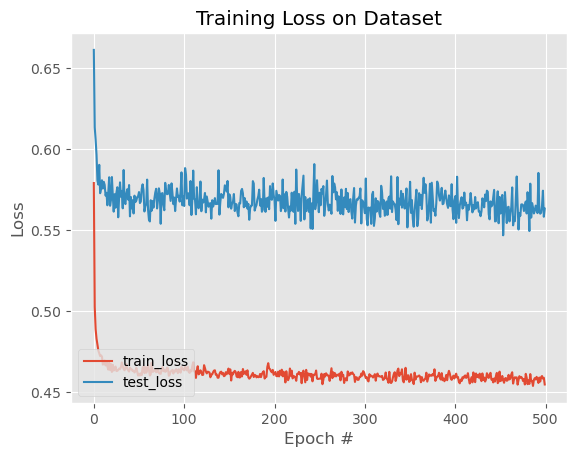

In [122]:
# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(num_epochs)):
    # set the model in training mode
    unet.train()
    # initialize the total training and validation loss
    totalTrainLoss = 0
    totalTestLoss = 0
    # loop over the training set
    for (i, (x, y)) in enumerate(trainLoader):
        # send the input to the device
        (x, y) = (x.to(device), y.to(device))
        # perform a forward pass and calculate the training loss
        pred = unet(x)
        loss = lossFunc(pred, y)
        # first, zero out any previously accumulated gradients, then
        # perform backpropagation, and then update model parameters
        opt.zero_grad()
        loss.backward()
        opt.step()
        # add the loss to the total training loss so far
        totalTrainLoss += loss
    # switch off autograd
    with torch.no_grad():
        # set the model in evaluation mode
        unet.eval()
        # loop over the validation set
        for (x, y) in testLoader:
            # send the input to the device
            (x, y) = (x.to(device), y.to(device))
            # make the predictions and calculate the validation loss
            pred = unet(x)
            totalTestLoss += lossFunc(pred, y)
    # calculate the average training and validation loss
    avgTrainLoss = totalTrainLoss / trainSteps
    avgTestLoss = totalTestLoss / testSteps
    # update our training history
    H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    H["test_loss"].append(avgTestLoss.cpu().detach().numpy())
    # print the model training and validation information
    print("[INFO] EPOCH: {}/{}".format(e + 1, num_epochs))
    print("Train loss: {:.6f}, Test loss: {:.4f}".format(
        avgTrainLoss, avgTestLoss))
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
    endTime - startTime))
# plot the training loss
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["test_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(plot_path)
# serialize the model to disk
torch.save(unet, model_path)

In [310]:
import skimage.metrics as metrics
from skimage.metrics import structural_similarity as ssim
import imageio
import lpips


def prepare_plot(original_image: np.ndarray, original_mask: np.ndarray, predicted_mask: np.ndarray) -> None:
    """Prepares a plot with three subplots showing the original image, the ground truth mask, and the predicted mask."""
    # Calculate the 1st and 99th percentiles of the original and predicted masks
    original_q1, original_q99 = np.percentile(original_mask, (1, 99))
    predicted_q1, predicted_q99 = np.percentile(predicted_mask, (1, 99))
    original_min, original_max = original_mask.min(), original_mask.max() 
    predicted_min, predicted_max = predicted_mask.min(), predicted_mask.max() 
    print(f"Original mask range: {original_min:.4f} - {original_max:.4f}")
    print(f"Original mask 1st and 99th percentiles: {original_q1:.4f} - {original_q99:.4f}")
    print(f"Predicted mask range: {predicted_min:.4f} - {predicted_max:.4f}")
    print(f"Predicted mask 1st and 99th percentiles: {predicted_q1:.4f} - {predicted_q99:.4f}")

    # Calculate metrics
    mse = np.mean((original_mask - predicted_mask) ** 2)
    rmse = np.sqrt(mse)
    psnr = 20 * np.log10(1 / np.sqrt(np.mean((original_mask - predicted_mask) ** 2)))
    ssim_ = ssim(original_mask, predicted_mask)

    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 3))
    axes[0].imshow(original_image)
    axes[0].grid(False)
    axes[0].set_title("PPL + XPL")
    axes[1].imshow(original_mask, cmap='gray', vmin=0, vmax=.45)
    axes[1].grid(False)
    axes[1].set_title("Original SE")
    axes[2].imshow(predicted_mask, cmap='gray', vmin=0, vmax=.45)
    axes[2].grid(False)
    axes[2].set_title("Predicted SE")
    axes[3].hist(original_mask.flatten(), bins=20, range=(0, .45), label='original', histtype='step')
    axes[3].hist(predicted_mask.flatten(), bins=20, range=(0, .45), label='prediction', histtype='step')
    axes[3].legend(loc='upper right')
    axes[3].grid(False)
    axes[3].text(0.45, 5000, f"MSE: {mse:.3f}\nRMSE: {rmse:.2f}\nPSNR: {psnr:.2f}\nSSIM: {ssim_:.2f}", fontsize=10)
    axes[3].set_xlim([0,0.8])
    fig.tight_layout()
    plt.show()


def save_predictions(original, prediction, filename):
    prediction_output = f"{base_output}\\predicted_images\\prediction_{filename}"
    original_output = f"{base_output}\\predicted_images\\original_{filename}"
    prediction = prediction*255
    original = original*255
    imageio.imwrite(prediction_output, prediction.astype(np.uint8)) 
    imageio.imwrite(original_output, original.astype(np.uint8)) 
    print(f"prediction saved to {prediction_output}")
    
    
def make_predictions(model: torch.nn.Module, image_path: str) -> None:
    """Takes a trained model and an image file path and generates a predicted mask."""
    model.eval()

    with torch.no_grad():
        
        # Load image and ground truth mask
        img_1 = np.array(Image.open(image_path).convert("RGB"), dtype=np.float32) / 255.0
        img_2_path = image_path.replace("PPL", "XPL")
        img_2 = np.array(Image.open(img_2_path).convert("RGB"), dtype=np.float32) / 255.0
        image = np.concatenate((img_1, img_2), axis=-1)
        #image = img_1
        original = image.copy()

        filename = os.path.split(image_path)[-1]
        ground_truth_path = os.path.join(mask_dataset_path, filename) 
        ground_truth_mask = np.array(Image.open(ground_truth_path).convert("L"), dtype=np.float32) / 255.0

        # Prepare input for model
        image = np.transpose(image, (2, 0, 1))
        image = np.expand_dims(image, 0)
        image = torch.from_numpy(image).to(device)

        # Generate predicted mask
        predicted_mask = model(image).squeeze()
        predicted_mask = torch.sigmoid(predicted_mask)
        predicted_mask = predicted_mask.cpu().numpy()
        
        # Visualize results
        prepare_plot(original[:,:,0:3], ground_truth_mask, predicted_mask)
        # save_predictions(ground_truth_mask, predicted_mask, filename)

In [311]:
# load the image paths in our testing file and randomly select 10 image paths
print("[INFO] loading up test image paths...")
imagePaths = open(test_paths).read().strip().split("\n")
# imagePaths = np.random.choice(imagePaths, size=10)

[INFO] loading up test image paths...


In [312]:
# load our model from disk and flash it to the current device
print("[INFO] load up model...")
unet = torch.load(model_path).to(device)

[INFO] load up model...


Original mask range: 0.0039 - 0.9373
Original mask 1st and 99th percentiles: 0.0588 - 0.4980
Predicted mask range: 0.0768 - 0.3162
Predicted mask 1st and 99th percentiles: 0.1026 - 0.2918


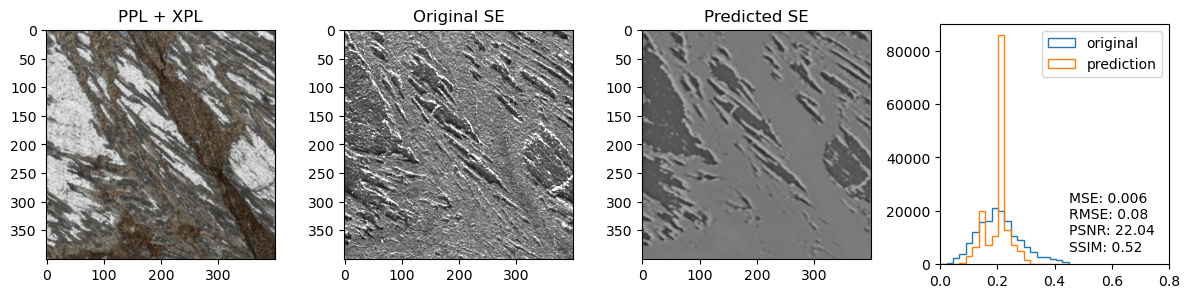

In [313]:
plt.style.use('default')
make_predictions(unet, 'dataset\\PPL\\A_0163.png')

In [155]:
imagePaths

['dataset\\PPL\\A_0155.png',
 'dataset\\PPL\\A_0216.png',
 'dataset\\PPL\\A_0016.png',
 'dataset\\PPL\\A_0174.png',
 'dataset\\PPL\\A_0159.png',
 'dataset\\PPL\\A_0126.png',
 'dataset\\PPL\\A_0098.png',
 'dataset\\PPL\\A_0026.png',
 'dataset\\PPL\\A_0061.png',
 'dataset\\PPL\\A_0069.png',
 'dataset\\PPL\\A_0127.png',
 'dataset\\PPL\\A_0164.png',
 'dataset\\PPL\\A_0143.png',
 'dataset\\PPL\\A_0116.png',
 'dataset\\PPL\\A_0046.png',
 'dataset\\PPL\\A_0010.png',
 'dataset\\PPL\\A_0101.png',
 'dataset\\PPL\\A_0097.png',
 'dataset\\PPL\\A_0019.png',
 'dataset\\PPL\\A_0177.png',
 'dataset\\PPL\\A_0083.png',
 'dataset\\PPL\\A_0031.png',
 'dataset\\PPL\\A_0191.png']

In [156]:
# iterate over the randomly selected test image paths
for path in imagePaths:
    # make predictions and visualize the results
    make_predictions(unet, path)

prediction saved to output_SE\predicted_images\prediction_A_0155.png
prediction saved to output_SE\predicted_images\prediction_A_0216.png
prediction saved to output_SE\predicted_images\prediction_A_0016.png
prediction saved to output_SE\predicted_images\prediction_A_0174.png
prediction saved to output_SE\predicted_images\prediction_A_0159.png
prediction saved to output_SE\predicted_images\prediction_A_0126.png
prediction saved to output_SE\predicted_images\prediction_A_0098.png
prediction saved to output_SE\predicted_images\prediction_A_0026.png
prediction saved to output_SE\predicted_images\prediction_A_0061.png
prediction saved to output_SE\predicted_images\prediction_A_0069.png
prediction saved to output_SE\predicted_images\prediction_A_0127.png
prediction saved to output_SE\predicted_images\prediction_A_0164.png
prediction saved to output_SE\predicted_images\prediction_A_0143.png
prediction saved to output_SE\predicted_images\prediction_A_0116.png
prediction saved to output_SE\pred

In [ ]:
# Count the number of parameters
num_params = sum(p.numel() for p in unet.parameters())
print("Number of parameters in the model:", num_params)